# Perceptron for tree height modeling

In [12]:
# Ref: https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb

'''
Packages (Installation from scratch)
conda create -n geo_comp2 python=3.8
conda activate geo_comp2
conda install pytorch==1.12.0 torchvision==0.13.0 cudatoolkit=11.3 -c pytorch
conda install -c conda-forge jupyterlab
conda install -c conda-forge matplotlib
conda install -c anaconda scikit-learn
conda install -c anaconda pandas
conda install -c anaconda scipy



if you have gpus: conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
for cpu only: conda install pytorch torchvision torchaudio cpuonly -c pytorch
conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch
conda install -c anaconda scikit-learn
conda install pandas
'''
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from scipy import stats

"""
Fix random seeds.
"""
seed=31
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


We already have seen how to design a simple Perceptron to perform a regression. Also, we observed that the normalization of the data and target should match the structure of our model. However, just guaranteeing the data is in the correct range is not enough. Let's see how it works.

In [4]:
# #What are we trying to beat
# data = pd.read_csv('./tree_height/txt/eu_x_y_height_predictors.txt',  sep=" ")
# # data = pd.read_csv('./tree_height/txt/eu_x_y_height.txt',  sep=" ")
# print(data.shape)
# print(data.head())

# y_true = data['h']
# y_pred = data['forest_height']

# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_true)

# fig,ax=plt.subplots(1,1,figsize=(5,5))
# ax.scatter(y_pred, y_true)
# ax.set_xlabel('Prediction')
# ax.set_ylabel('True')
# ax.set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))
# plt.show()

Let's start by loading the data we used in the previous class

In [5]:
### Try the the tree height with Perceptron 
# data = pd.read_csv('./tree_height/txt/eu_x_y_height_predictors.txt',  sep=" ")
# data = pd.read_csv('./tree_height/txt/eu_x_y_height.txt',  sep=" ")
data = pd.read_csv("./tree_height_2/txt/eu_x_y_height_predictors_select.txt", sep=" ",  index_col=False)
print(data.shape)
print(data.head())

(1267239, 23)
   ID         X          Y        h  BLDFIE_WeigAver  CECSOL_WeigAver  \
0   1  6.050001  49.727499  3139.00             1540               13   
1   2  6.050002  49.922155  1454.75             1491               12   
2   3  6.050002  48.602377   853.50             1521               17   
3   4  6.050009  48.151979  3141.00             1526               16   
4   5  6.050010  49.588410  2065.25             1547               14   

   CHELSA_bio18  CHELSA_bio4  convergence        cti  ...  forestheight  \
0          2113         5893   -10.486560 -238043120  ...            23   
1          1993         5912    33.274361 -208915344  ...            19   
2          2124         5983     0.045293 -137479792  ...            21   
3          2569         6130   -33.654274 -267223072  ...            27   
4          2108         5923    27.493824 -107809368  ...            25   

   glad_ard_SVVI_max  glad_ard_SVVI_med  glad_ard_SVVI_min  northness  \
0         276.871094   

In [6]:
#Keep just few columns
data = data.iloc[:,1:4]
print(data.shape)
print(data.head())

(1267239, 3)
          X          Y        h
0  6.050001  49.727499  3139.00
1  6.050002  49.922155  1454.75
2  6.050002  48.602377   853.50
3  6.050009  48.151979  3141.00
4  6.050010  49.588410  2065.25


Once again, let's take a look at the distributions and range of our data

(array([8.96640e+04, 5.91560e+04, 6.27730e+04, 7.68820e+04, 9.90510e+04,
        1.20582e+05, 1.36417e+05, 1.50469e+05, 1.55594e+05, 1.31737e+05,
        9.07160e+04, 4.94050e+04, 2.35680e+04, 1.03910e+04, 4.47900e+03,
        1.93800e+03, 9.18000e+02, 5.20000e+02, 3.57000e+02, 2.92000e+02,
        2.79000e+02, 1.95000e+02, 2.02000e+02, 1.98000e+02, 1.64000e+02,
        1.59000e+02, 1.41000e+02, 1.14000e+02, 1.22000e+02, 9.30000e+01,
        1.02000e+02, 9.70000e+01, 6.80000e+01, 6.90000e+01, 5.20000e+01,
        3.40000e+01, 3.30000e+01, 3.80000e+01, 2.40000e+01, 2.20000e+01,
        2.40000e+01, 1.80000e+01, 1.40000e+01, 1.60000e+01, 1.00000e+01,
        9.00000e+00, 1.40000e+01, 5.00000e+00, 6.00000e+00, 8.00000e+00]),
 array([   84.75 ,   372.675,   660.6  ,   948.525,  1236.45 ,  1524.375,
         1812.3  ,  2100.225,  2388.15 ,  2676.075,  2964.   ,  3251.925,
         3539.85 ,  3827.775,  4115.7  ,  4403.625,  4691.55 ,  4979.475,
         5267.4  ,  5555.325,  5843.25 ,  6131

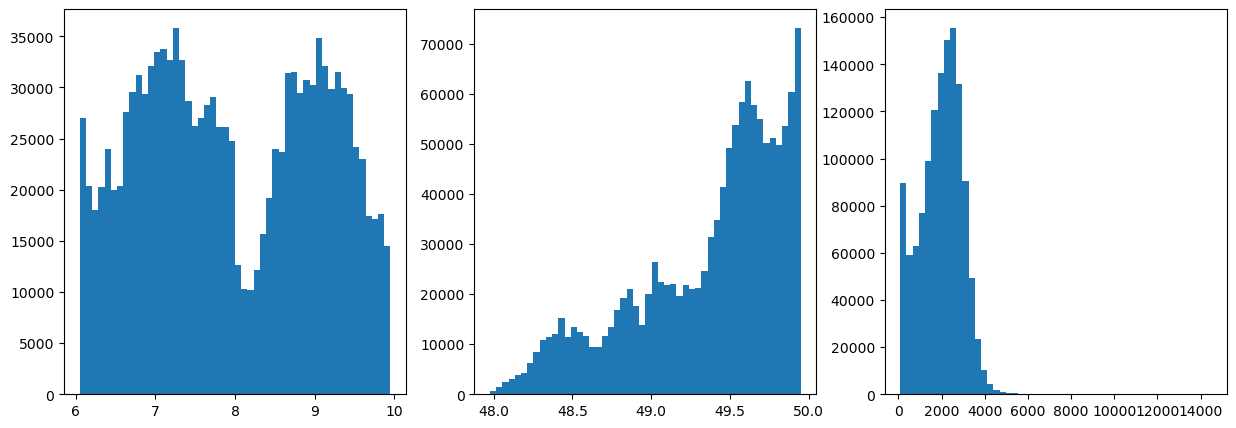

In [7]:
#Explore the raw data
data = data.to_numpy()
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].hist(data[:,0],50)
ax[1].hist(data[:,1],50)
ax[2].hist(data[:,2],50)

Now we normalize the data

(array([8.96640e+04, 5.91560e+04, 6.27730e+04, 7.68820e+04, 9.90510e+04,
        1.20582e+05, 1.36417e+05, 1.50469e+05, 1.55594e+05, 1.31886e+05,
        9.05670e+04, 4.94050e+04, 2.35680e+04, 1.03910e+04, 4.47900e+03,
        1.93800e+03, 9.18000e+02, 5.20000e+02, 3.57000e+02, 2.92000e+02,
        2.79000e+02, 1.95000e+02, 2.02000e+02, 1.98000e+02, 1.64000e+02,
        1.59000e+02, 1.41000e+02, 1.14000e+02, 1.22000e+02, 9.30000e+01,
        1.02000e+02, 9.70000e+01, 6.80000e+01, 6.90000e+01, 5.20000e+01,
        3.40000e+01, 3.30000e+01, 3.80000e+01, 2.40000e+01, 2.20000e+01,
        2.40000e+01, 1.80000e+01, 1.40000e+01, 1.60000e+01, 1.00000e+01,
        9.00000e+00, 1.40000e+01, 5.00000e+00, 6.00000e+00, 8.00000e+00]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.

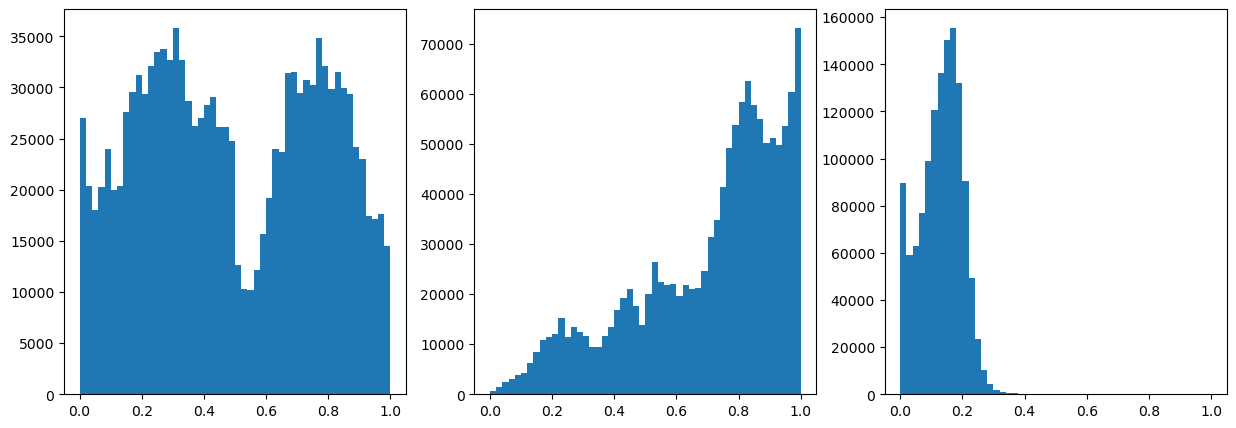

In [8]:
#Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].hist(data[:,0],50)
ax[1].hist(data[:,1],50)
ax[2].hist(data[:,2],50)

In [9]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split(data[:,:2], data[:,2], test_size=0.30, random_state=0)
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)
print('X_train.shape: {}, X_test.shape: {}, y_train.shape: {}, y_test.shape: {}'.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

X_train.shape: torch.Size([887067, 2]), X_test.shape: torch.Size([380172, 2]), y_train.shape: torch.Size([887067]), y_test.shape: torch.Size([380172])


Finally, let's create and initialize our Perceptron

In [10]:
# Create the model
class Perceptron(torch.nn.Module):
    def __init__(self,input_size, output_size,use_activation_fn=None):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_size,output_size)
        self.relu = torch.nn.ReLU() # instead of Heaviside step fn
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        self.use_activation_fn=use_activation_fn
    def forward(self, x):
        output = self.fc(x)
        if self.use_activation_fn=='sigmoid':
            output = self.sigmoid(output) # To add the non-linearity. Try training you Perceptron with and without the non-linearity
        elif self.use_activation_fn=='tanh':
            output = self.tanh(output) 
        elif self.use_activation_fn=='relu':
            output = self.relu(output) 

        return output

In [13]:
#Just in case, remember to always delete previously existent models before starting a new session
if 'model' in globals():
    print('Deleting previous model')
    del model, criterion, optimizer
model = Perceptron(input_size=2, output_size=1, use_activation_fn='sigmoid')
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

Let's train and check our model's performance

Test loss after Training 0.005871600937098265


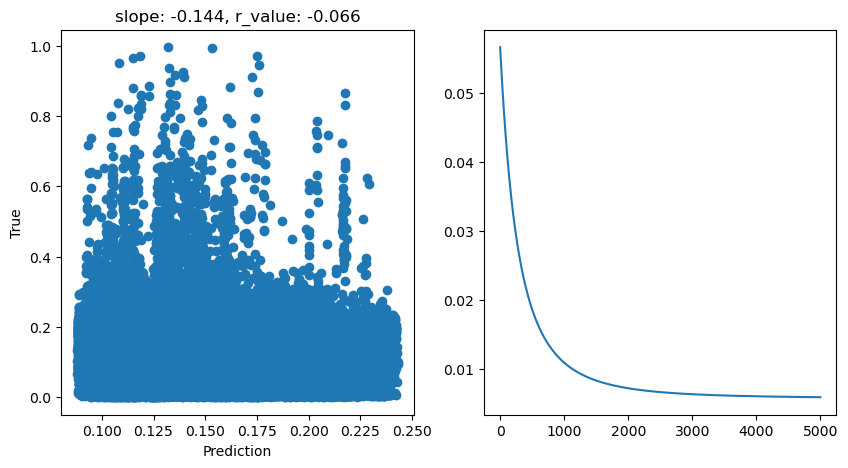

In [14]:
model.train()
epoch = 5000
all_loss=[]
for epoch in range(epoch):
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(X_train)
    # Compute Loss
    loss = criterion(y_pred.squeeze(), y_train)
   
    # Backward pass
    loss.backward()
    optimizer.step()
    
    all_loss.append(loss.item())
    
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    after_train = criterion(y_pred.squeeze(), y_test) 
    print('Test loss after Training' , after_train.item())

    y_pred = y_pred.detach().numpy().squeeze()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_test)

    # Fit line
    # x = np.arange(-150,150)

    fig,ax=plt.subplots(1,2,figsize=(10,5))
    ax[1].plot(all_loss)
    ax[0].scatter(y_pred, y_test)
    # ax[0].plot(x, intercept + slope*x, 'r', label='fitted line')
    ax[0].set_xlabel('Prediction')
    ax[0].set_ylabel('True')
    ax[0].set_title('slope: {:.3f}, r_value: {:.3f}'.format(slope, r_value))

Well, they all performed badly. What can we do to make this model better? One thing that immediatly jumps to our eyes is the fact that this data is very skewed. There are many ways to normalized sweked data. Check out this great post about normalization and popular power transformations [power transformations](https://www.baeldung.com/cs/normalizing-inputs-artificial-neural-network). Here I will introduce another one: the Quantile Transformation. Also, if you would like to see a great comparison between transformations, check out this skelarn [post](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html) 

For now, let's use the power transformation just for our target variable (ie, tree height).

In [15]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(
    n_quantiles=500, output_distribution="normal", random_state=0
)

# X_train, X_test = train_test_split(data, test_size=0.5)
# data = qt.fit_transform(data)
data[:,2] = qt.fit_transform(data[:,2].reshape(-1,1)).squeeze()

(array([6.40000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 8.00000e+00,
        5.00000e+00, 1.60000e+01, 4.10000e+01, 1.04000e+02, 4.76000e+02,
        1.75900e+03, 2.88100e+03, 4.45900e+03, 6.93700e+03, 9.86300e+03,
        1.22210e+04, 2.18220e+04, 3.01310e+04, 4.54470e+04, 5.62710e+04,
        6.77220e+04, 7.39930e+04, 8.85820e+04, 1.03028e+05, 1.08294e+05,
        1.03491e+05, 9.61700e+04, 9.32570e+04, 8.00070e+04, 6.65440e+04,
        5.62140e+04, 4.55490e+04, 3.18110e+04, 1.88250e+04, 1.54770e+04,
        1.08020e+04, 6.05500e+03, 4.45700e+03, 2.01500e+03, 1.54800e+03,
        4.38000e+02, 1.48000e+02, 4.60000e+01, 1.80000e+01, 3.00000e+00,
        5.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.35000e+02]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32

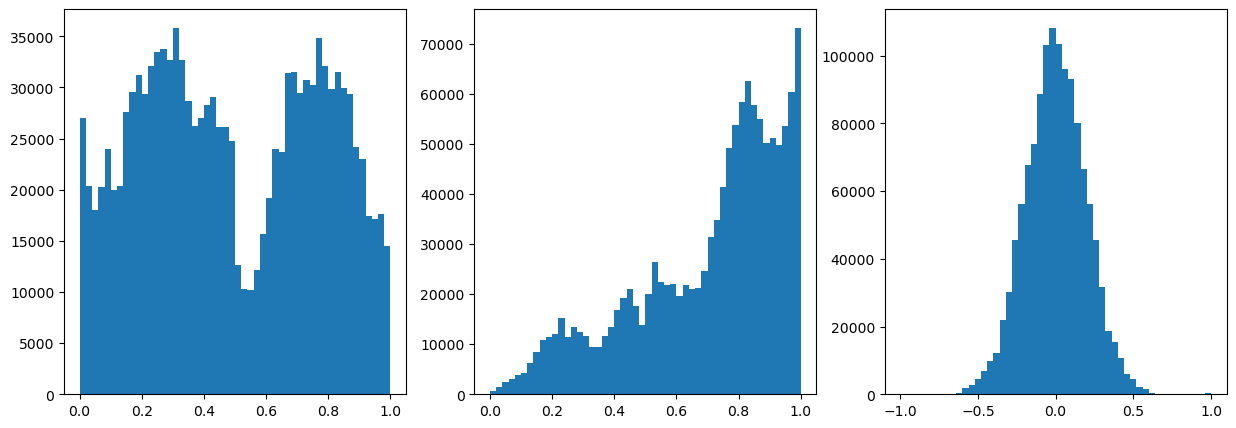

In [16]:
#Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data[:,2] = ((data[:,2]-data[:,2].min())/(data[:,2].max()-data[:,2].min()))*2-1
# data[:,2] = data[:,2]/np.quantile(np.abs(data[:,2]),0.99)
data[:,2] = data[:,2]/data[:,2].max()
# data = data/np.quantile(np.abs(data),0.99)
# data = data/data.max()
# print(data.shape)
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].hist(data[:,0],50)
ax[1].hist(data[:,1],50)
ax[2].hist(data[:,2],50)

In [17]:
# Let's use all the data as one big minibatch

#Split the data
X_train, X_test, y_train, y_test = train_test_split(data[:,:2], data[:,2], test_size=0.30, random_state=0)
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)
print('X_train.shape: {}, X_test.shape: {}, y_train.shape: {}, y_test.shape: {}'.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))
print('X_train.min: {}, X_test.shape: {}, y_train.shape: {}, y_test.shape: {}'.format(X_train.min(), X_test.min(), y_train.min(), y_test.min()))
print('X_train.max: {}, X_test.shape: {}, y_train.shape: {}, y_test.shape: {}'.format(X_train.max(), X_test.max(), y_train.max(), y_test.max()))

X_train.shape: torch.Size([887067, 2]), X_test.shape: torch.Size([380172, 2]), y_train.shape: torch.Size([887067]), y_test.shape: torch.Size([380172])
X_train.min: 0.0, X_test.shape: 0.0, y_train.shape: -1.0, y_test.shape: -1.0
X_train.max: 1.0, X_test.shape: 1.0, y_train.shape: 1.0, y_test.shape: 1.0



hid_dim: 1, lr: 0.5
Deleting previous model
Epoch 0, train_loss: 0.2698, val_loss: 0.0818, r_value: -0.0894
Epoch 100, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0892
Epoch 200, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0892
Epoch 300, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0892
Epoch 400, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0892
Epoch 500, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0892
Epoch 600, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0892
Epoch 700, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0892
Epoch 800, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0892
Epoch 900, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0892
Epoch 1000, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0892
Epoch 1100, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0892
Epoch 1200, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0892
Epoch 1300, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0892
Epoch 1400, train_loss: 0.0373, val_loss: 

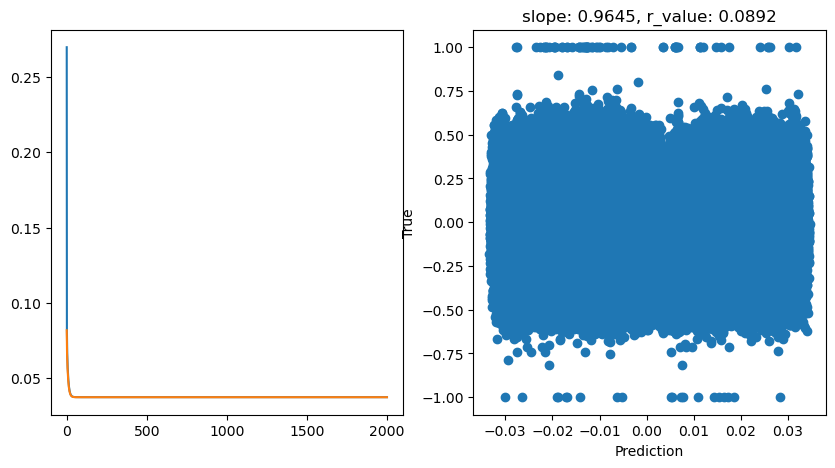


hid_dim: 1, lr: 0.1
Deleting previous model
Epoch 0, train_loss: 0.6674, val_loss: 0.6119, r_value: 0.0545
Epoch 100, train_loss: 0.0375, val_loss: 0.0375, r_value: 0.0678
Epoch 200, train_loss: 0.0374, val_loss: 0.0373, r_value: 0.0834
Epoch 300, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0876
Epoch 400, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0887
Epoch 500, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0890
Epoch 600, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0891
Epoch 700, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0892
Epoch 800, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0892
Epoch 900, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0892
Epoch 1000, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0892
Epoch 1100, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0892
Epoch 1200, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0892
Epoch 1300, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0892
Epoch 1400, train_loss: 0.0373, val_loss: 0

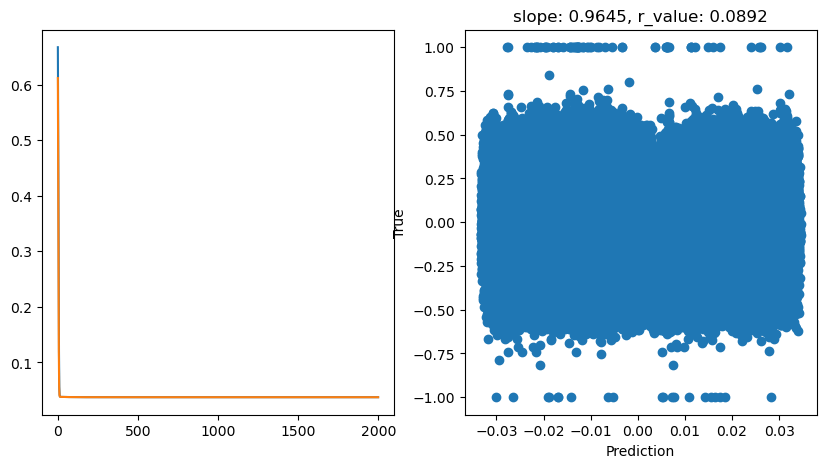


hid_dim: 1, lr: 0.01
Deleting previous model
Epoch 0, train_loss: 0.2034, val_loss: 0.1965, r_value: -0.0886
Epoch 100, train_loss: 0.0656, val_loss: 0.0652, r_value: -0.0892
Epoch 200, train_loss: 0.0594, val_loss: 0.0590, r_value: -0.0890
Epoch 300, train_loss: 0.0546, val_loss: 0.0543, r_value: -0.0889
Epoch 400, train_loss: 0.0509, val_loss: 0.0506, r_value: -0.0888
Epoch 500, train_loss: 0.0479, val_loss: 0.0476, r_value: -0.0887
Epoch 600, train_loss: 0.0455, val_loss: 0.0453, r_value: -0.0886
Epoch 700, train_loss: 0.0437, val_loss: 0.0435, r_value: -0.0885
Epoch 800, train_loss: 0.0423, val_loss: 0.0421, r_value: -0.0883
Epoch 900, train_loss: 0.0412, val_loss: 0.0410, r_value: -0.0881
Epoch 1000, train_loss: 0.0403, val_loss: 0.0402, r_value: -0.0878
Epoch 1100, train_loss: 0.0396, val_loss: 0.0395, r_value: -0.0875
Epoch 1200, train_loss: 0.0391, val_loss: 0.0390, r_value: -0.0869
Epoch 1300, train_loss: 0.0387, val_loss: 0.0386, r_value: -0.0861
Epoch 1400, train_loss: 0.03

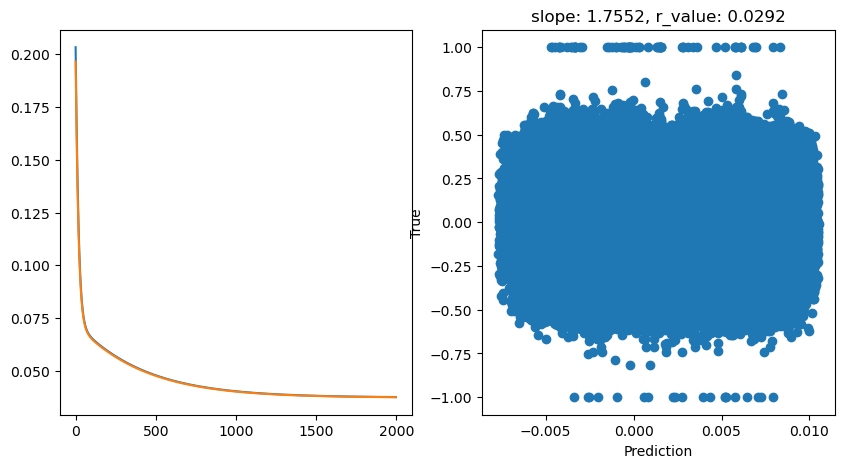

In [23]:
# model.train()
epoch = 2000
hid_dim_range = [1]
lr_range = [0.5,0.1,0.01]#,0.05,0.001]

for hid_dim in hid_dim_range:
    for lr in lr_range:
        print('\nhid_dim: {}, lr: {}'.format(hid_dim, lr))
        if 'model' in globals():
            print('Deleting previous model')
            del model, criterion, optimizer
        model = Perceptron(2, hid_dim,use_activation_fn='tanh').to(device)
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr = lr)

        all_loss_train=[]
        all_loss_val=[]
        for epoch in range(epoch):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(X_train.to(device))
            # Compute Loss
            loss = criterion(y_pred.squeeze(), y_train.to(device))

            # Backward pass
            loss.backward()
            optimizer.step()

            all_loss_train.append(loss.item())

            model.eval()
            with torch.no_grad():
                y_pred = model(X_test.to(device))
                # Compute Loss
                loss = criterion(y_pred.squeeze(), y_test.to(device))
                all_loss_val.append(loss.item())
            
                if epoch%100==0:
                    y_pred = y_pred.cpu().detach().numpy().squeeze()
                    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_test)
                    print('Epoch {}, train_loss: {:.4f}, val_loss: {:.4f}, r_value: {:.4f}'.format(epoch,all_loss_train[-1],all_loss_val[-1],r_value))
                
        fig,ax=plt.subplots(1,2,figsize=(10,5))
        ax[0].plot(all_loss_train)
        ax[0].plot(all_loss_val)

        ax[1].scatter(y_pred.cpu(), y_test.cpu())
        ax[1].set_xlabel('Prediction')
        ax[1].set_ylabel('True')
        ax[1].set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))
        plt.show()

Feel free to try other hyperparameters, but we already have seen that there is just so much a Perceptron can do. It's time to scale up this problem. 
(BACK TO SLIDES)

## Feedfoward neural network

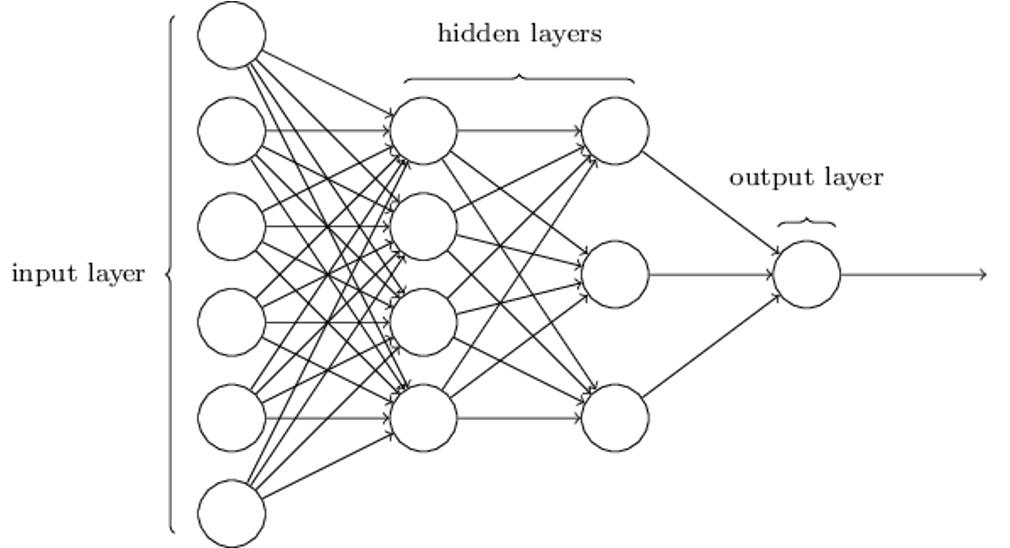

In [24]:
# Try with FF
class Feedforward(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        # self.fc3 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        # self.fc4 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(self.hidden_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
    def forward(self, x):
        hidden = self.relu(self.fc1(x))
        hidden = self.relu(self.fc2(hidden))
        # hidden = self.relu(self.fc3(hidden))
        # hidden = self.relu(self.fc4(hidden))
        output = self.tanh(self.fc3(hidden))

        return output


hid_dim: 128, lr: 0.75
Deleting previous model
Epoch 0, train_loss: 0.0454, val_loss: 0.4352, r_value: 0.0631
Epoch 200, train_loss: 0.0374, val_loss: 0.0374, r_value: 0.0945
Epoch 400, train_loss: 0.0373, val_loss: 0.0372, r_value: 0.1037
Epoch 600, train_loss: 0.0373, val_loss: 0.0372, r_value: 0.1094
Epoch 800, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.1149
Epoch 1000, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.1206
Epoch 1200, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.1267
Epoch 1400, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.1396
Epoch 1600, train_loss: 0.0374, val_loss: 0.0374, r_value: 0.1543
Epoch 1800, train_loss: 0.0374, val_loss: 0.0374, r_value: 0.1659


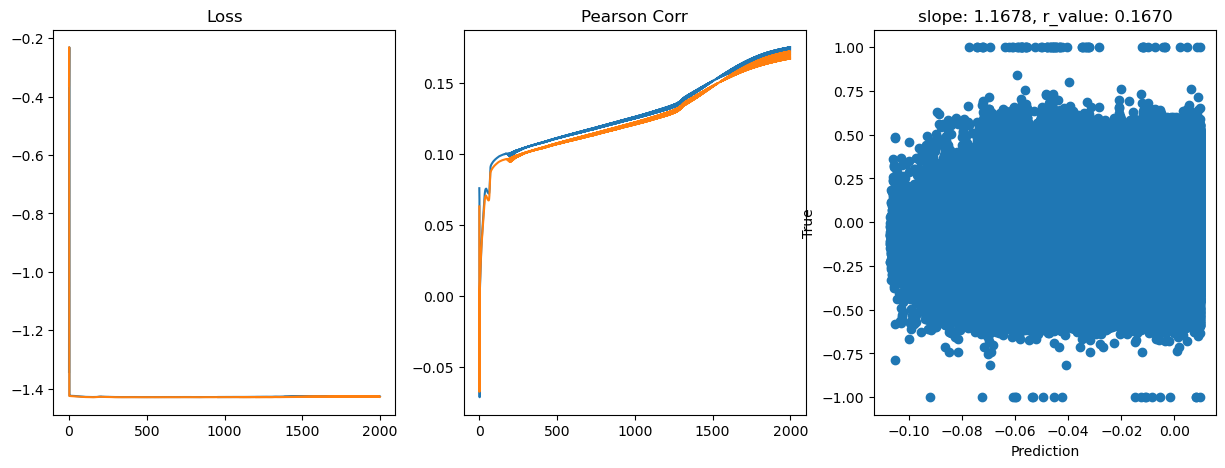

Saving model to  ./models/model_SGD_2000_lr0.75_hid_dim128

hid_dim: 128, lr: 0.5
Deleting previous model
Epoch 0, train_loss: 0.0487, val_loss: 0.4800, r_value: 0.0552
Epoch 200, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1086
Epoch 400, train_loss: 0.0371, val_loss: 0.0371, r_value: 0.1185
Epoch 600, train_loss: 0.0370, val_loss: 0.0370, r_value: 0.1298
Epoch 800, train_loss: 0.0370, val_loss: 0.0370, r_value: 0.1370
Epoch 1000, train_loss: 0.0370, val_loss: 0.0370, r_value: 0.1464
Epoch 1200, train_loss: 0.0370, val_loss: 0.0370, r_value: 0.1546
Epoch 1400, train_loss: 0.0369, val_loss: 0.0369, r_value: 0.1608
Epoch 1600, train_loss: 0.0369, val_loss: 0.0369, r_value: 0.1650
Epoch 1800, train_loss: 0.0369, val_loss: 0.0368, r_value: 0.1683


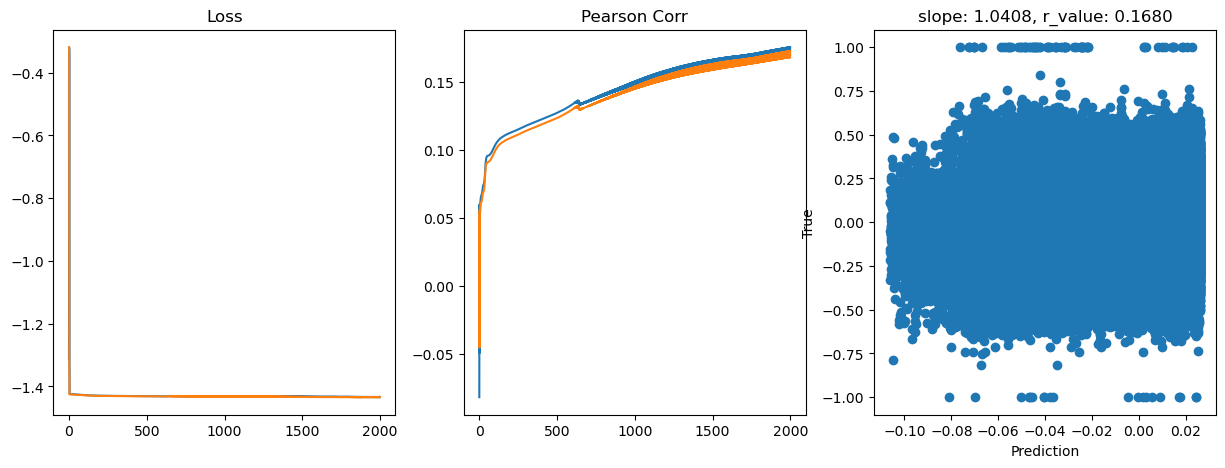

Saving model to  ./models/model_SGD_2000_lr0.5_hid_dim128

hid_dim: 128, lr: 0.1
Deleting previous model
Epoch 0, train_loss: 0.0570, val_loss: 0.0402, r_value: 0.0208
Epoch 200, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1067
Epoch 400, train_loss: 0.0371, val_loss: 0.0371, r_value: 0.1161
Epoch 600, train_loss: 0.0371, val_loss: 0.0370, r_value: 0.1234
Epoch 800, train_loss: 0.0370, val_loss: 0.0370, r_value: 0.1294
Epoch 1000, train_loss: 0.0370, val_loss: 0.0369, r_value: 0.1349
Epoch 1200, train_loss: 0.0369, val_loss: 0.0369, r_value: 0.1402
Epoch 1400, train_loss: 0.0369, val_loss: 0.0369, r_value: 0.1449
Epoch 1600, train_loss: 0.0369, val_loss: 0.0368, r_value: 0.1493
Epoch 1800, train_loss: 0.0368, val_loss: 0.0368, r_value: 0.1534


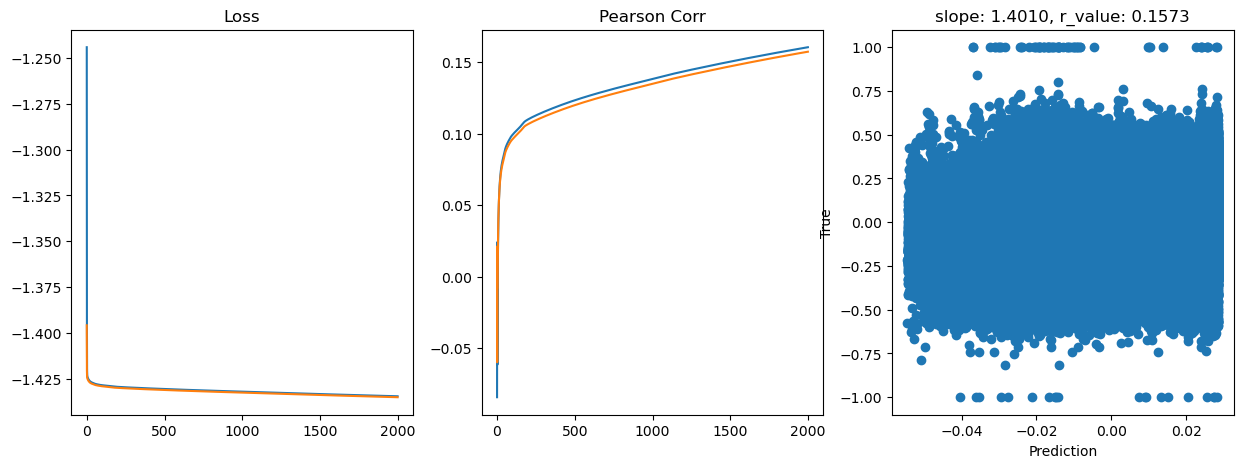

Saving model to  ./models/model_SGD_2000_lr0.1_hid_dim128

hid_dim: 128, lr: 0.01
Deleting previous model
Epoch 0, train_loss: 0.0375, val_loss: 0.0374, r_value: 0.0806
Epoch 200, train_loss: 0.0374, val_loss: 0.0373, r_value: 0.0877
Epoch 400, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0932
Epoch 600, train_loss: 0.0373, val_loss: 0.0372, r_value: 0.0978
Epoch 800, train_loss: 0.0373, val_loss: 0.0372, r_value: 0.1000
Epoch 1000, train_loss: 0.0373, val_loss: 0.0372, r_value: 0.1015
Epoch 1200, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1029
Epoch 1400, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1041
Epoch 1600, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1053
Epoch 1800, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1064


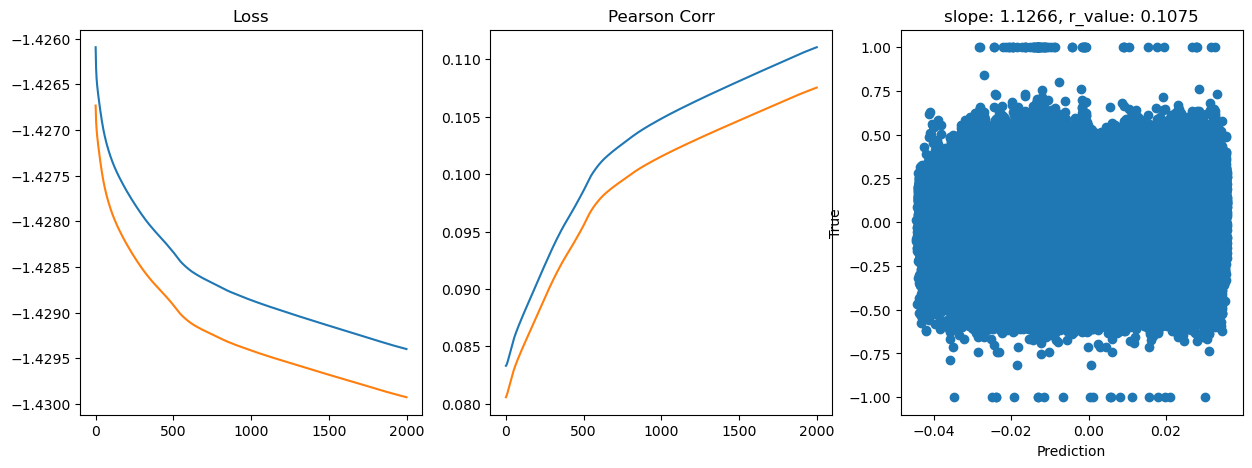

Saving model to  ./models/model_SGD_2000_lr0.01_hid_dim128

hid_dim: 128, lr: 0.05
Deleting previous model
Epoch 0, train_loss: 0.0401, val_loss: 0.0379, r_value: -0.0494
Epoch 200, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1058
Epoch 400, train_loss: 0.0372, val_loss: 0.0371, r_value: 0.1110
Epoch 600, train_loss: 0.0371, val_loss: 0.0371, r_value: 0.1164
Epoch 800, train_loss: 0.0371, val_loss: 0.0371, r_value: 0.1197
Epoch 1000, train_loss: 0.0371, val_loss: 0.0370, r_value: 0.1228
Epoch 1200, train_loss: 0.0371, val_loss: 0.0370, r_value: 0.1253
Epoch 1400, train_loss: 0.0371, val_loss: 0.0370, r_value: 0.1276
Epoch 1600, train_loss: 0.0370, val_loss: 0.0370, r_value: 0.1298
Epoch 1800, train_loss: 0.0370, val_loss: 0.0370, r_value: 0.1319


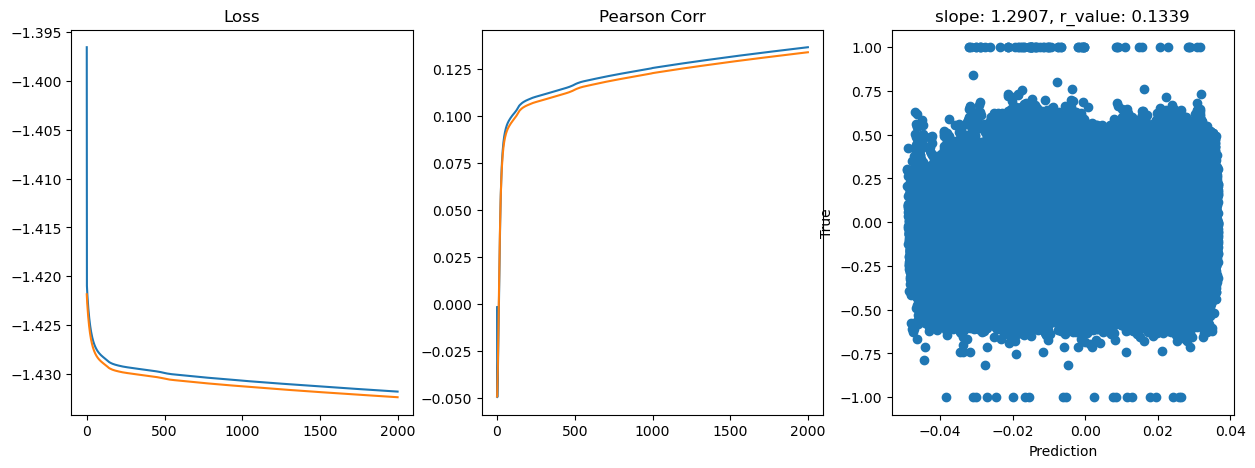

Saving model to  ./models/model_SGD_2000_lr0.05_hid_dim128

hid_dim: 128, lr: 0.001
Deleting previous model
Epoch 0, train_loss: 0.0405, val_loss: 0.0404, r_value: 0.0694
Epoch 200, train_loss: 0.0375, val_loss: 0.0374, r_value: 0.0754
Epoch 400, train_loss: 0.0374, val_loss: 0.0374, r_value: 0.0784
Epoch 600, train_loss: 0.0374, val_loss: 0.0374, r_value: 0.0808
Epoch 800, train_loss: 0.0374, val_loss: 0.0373, r_value: 0.0828
Epoch 1000, train_loss: 0.0374, val_loss: 0.0373, r_value: 0.0845
Epoch 1200, train_loss: 0.0374, val_loss: 0.0373, r_value: 0.0860
Epoch 1400, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0873
Epoch 1600, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0884
Epoch 1800, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0893


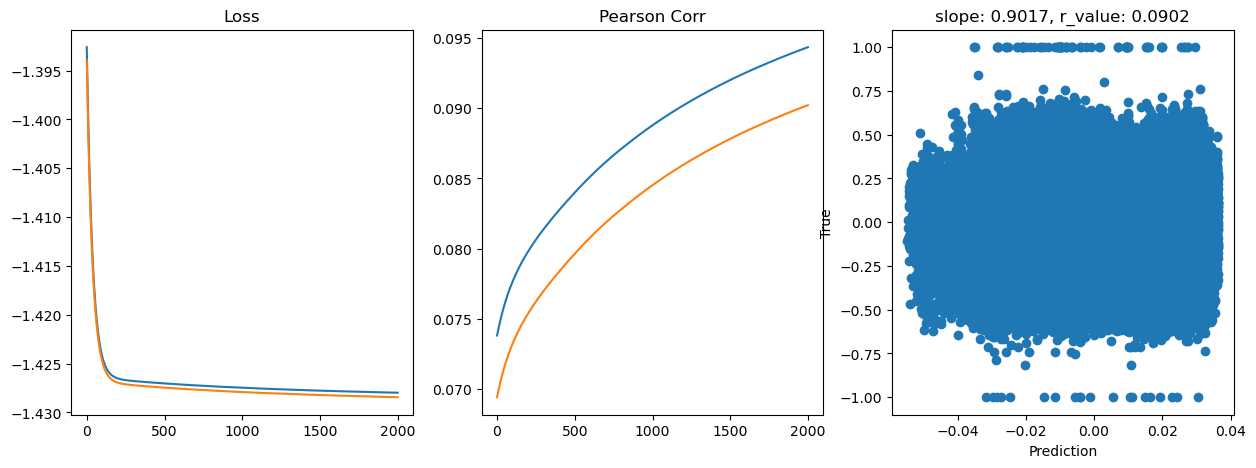

Saving model to  ./models/model_SGD_2000_lr0.001_hid_dim128

hid_dim: 256, lr: 0.75
Deleting previous model
Epoch 0, train_loss: 0.0393, val_loss: 0.4495, r_value: -0.0478
Epoch 200, train_loss: 0.0374, val_loss: 0.0373, r_value: 0.1175
Epoch 400, train_loss: 0.0375, val_loss: 0.0374, r_value: 0.1349
Epoch 600, train_loss: 0.0375, val_loss: 0.0374, r_value: 0.1429
Epoch 800, train_loss: 0.0375, val_loss: 0.0374, r_value: 0.1477
Epoch 1000, train_loss: 0.0375, val_loss: 0.0374, r_value: 0.1511
Epoch 1200, train_loss: 0.0374, val_loss: 0.0373, r_value: 0.1536
Epoch 1400, train_loss: 0.0374, val_loss: 0.0373, r_value: 0.1558
Epoch 1600, train_loss: 0.0374, val_loss: 0.0373, r_value: 0.1577
Epoch 1800, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.1592


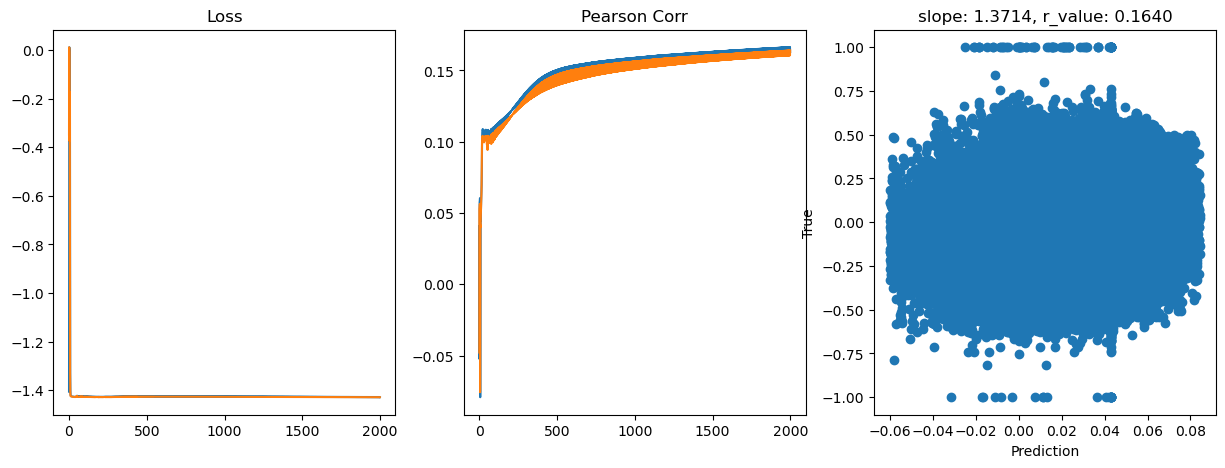

Saving model to  ./models/model_SGD_2000_lr0.75_hid_dim256

hid_dim: 256, lr: 0.5
Deleting previous model
Epoch 0, train_loss: 0.0378, val_loss: 0.0639, r_value: 0.0716
Epoch 200, train_loss: 0.0368, val_loss: 0.0368, r_value: 0.1494
Epoch 400, train_loss: 0.0366, val_loss: 0.0365, r_value: 0.1743
Epoch 600, train_loss: 0.0368, val_loss: 0.0368, r_value: 0.1793
Epoch 800, train_loss: 0.0368, val_loss: 0.0368, r_value: 0.1833
Epoch 1000, train_loss: 0.0368, val_loss: 0.0367, r_value: 0.1862
Epoch 1200, train_loss: 0.0367, val_loss: 0.0367, r_value: 0.1886
Epoch 1400, train_loss: 0.0367, val_loss: 0.0367, r_value: 0.1907
Epoch 1600, train_loss: 0.0367, val_loss: 0.0366, r_value: 0.1926
Epoch 1800, train_loss: 0.0367, val_loss: 0.0366, r_value: 0.1942


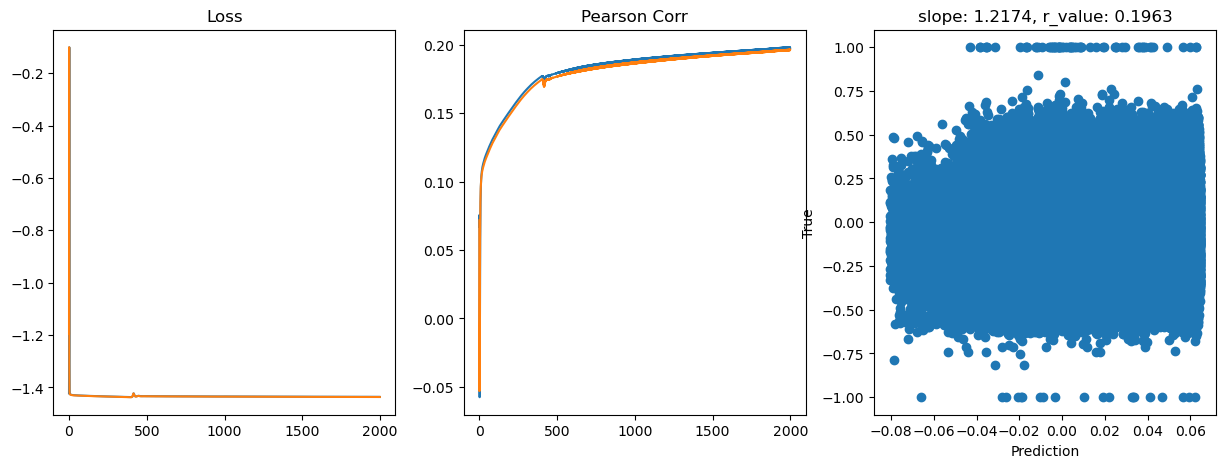

Saving model to  ./models/model_SGD_2000_lr0.5_hid_dim256

hid_dim: 256, lr: 0.1
Deleting previous model
Epoch 0, train_loss: 0.0399, val_loss: 0.0468, r_value: 0.0123
Epoch 200, train_loss: 0.0371, val_loss: 0.0370, r_value: 0.1260
Epoch 400, train_loss: 0.0370, val_loss: 0.0369, r_value: 0.1341
Epoch 600, train_loss: 0.0369, val_loss: 0.0369, r_value: 0.1406
Epoch 800, train_loss: 0.0369, val_loss: 0.0368, r_value: 0.1465
Epoch 1000, train_loss: 0.0368, val_loss: 0.0368, r_value: 0.1516
Epoch 1200, train_loss: 0.0368, val_loss: 0.0367, r_value: 0.1561
Epoch 1400, train_loss: 0.0367, val_loss: 0.0367, r_value: 0.1602
Epoch 1600, train_loss: 0.0367, val_loss: 0.0366, r_value: 0.1640
Epoch 1800, train_loss: 0.0366, val_loss: 0.0366, r_value: 0.1673


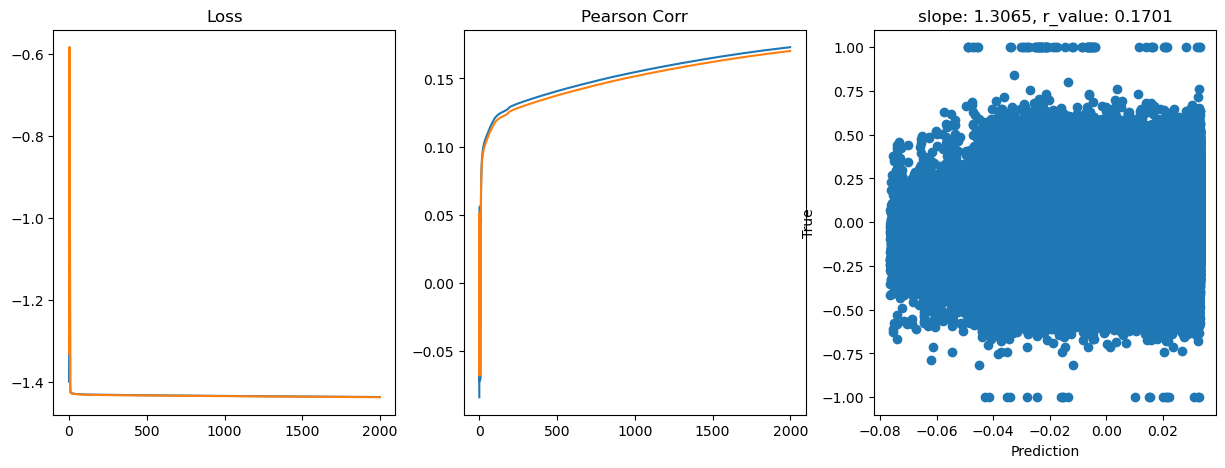

Saving model to  ./models/model_SGD_2000_lr0.1_hid_dim256

hid_dim: 256, lr: 0.01
Deleting previous model
Epoch 0, train_loss: 0.0468, val_loss: 0.0427, r_value: 0.0789
Epoch 200, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1083
Epoch 400, train_loss: 0.0371, val_loss: 0.0371, r_value: 0.1199
Epoch 600, train_loss: 0.0371, val_loss: 0.0370, r_value: 0.1256
Epoch 800, train_loss: 0.0370, val_loss: 0.0370, r_value: 0.1288
Epoch 1000, train_loss: 0.0370, val_loss: 0.0370, r_value: 0.1312
Epoch 1200, train_loss: 0.0370, val_loss: 0.0370, r_value: 0.1332
Epoch 1400, train_loss: 0.0370, val_loss: 0.0369, r_value: 0.1352
Epoch 1600, train_loss: 0.0370, val_loss: 0.0369, r_value: 0.1372
Epoch 1800, train_loss: 0.0370, val_loss: 0.0369, r_value: 0.1390


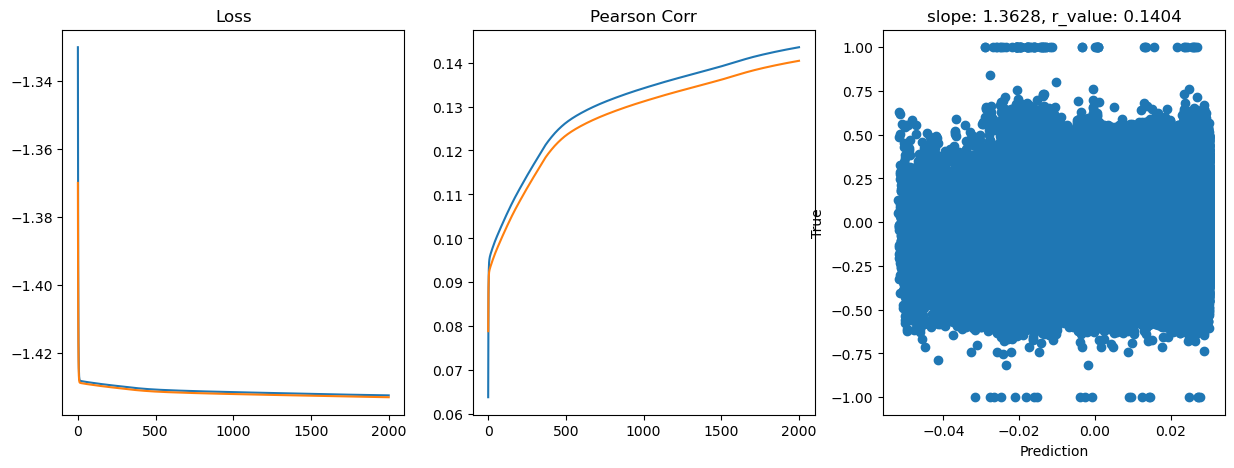

Saving model to  ./models/model_SGD_2000_lr0.01_hid_dim256

hid_dim: 256, lr: 0.05
Deleting previous model
Epoch 0, train_loss: 0.0537, val_loss: 0.0397, r_value: -0.0593
Epoch 200, train_loss: 0.0371, val_loss: 0.0370, r_value: 0.1251
Epoch 400, train_loss: 0.0370, val_loss: 0.0370, r_value: 0.1323
Epoch 600, train_loss: 0.0370, val_loss: 0.0369, r_value: 0.1380
Epoch 800, train_loss: 0.0369, val_loss: 0.0369, r_value: 0.1434
Epoch 1000, train_loss: 0.0369, val_loss: 0.0368, r_value: 0.1475
Epoch 1200, train_loss: 0.0368, val_loss: 0.0368, r_value: 0.1514
Epoch 1400, train_loss: 0.0368, val_loss: 0.0368, r_value: 0.1549
Epoch 1600, train_loss: 0.0368, val_loss: 0.0367, r_value: 0.1579
Epoch 1800, train_loss: 0.0367, val_loss: 0.0367, r_value: 0.1608


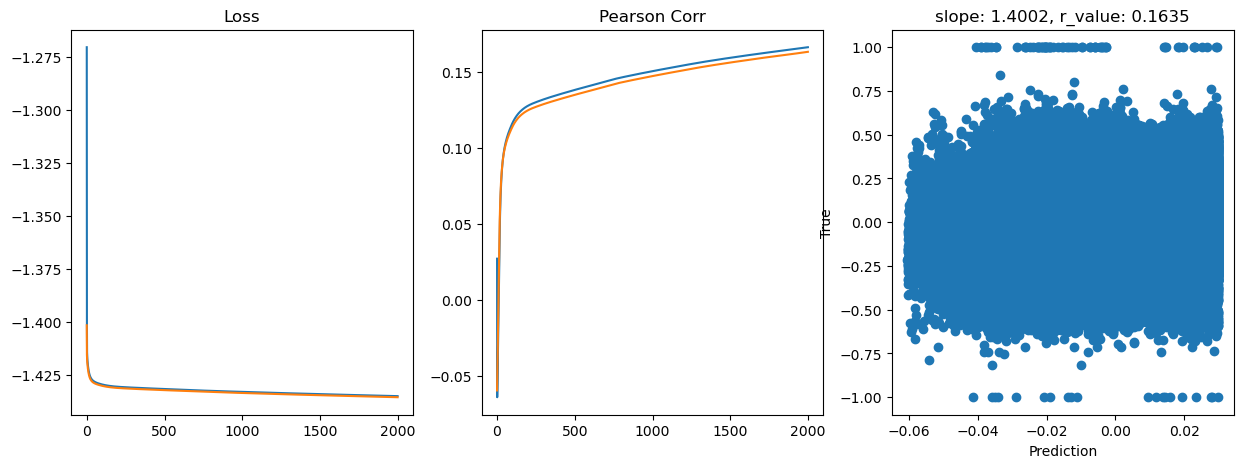

Saving model to  ./models/model_SGD_2000_lr0.05_hid_dim256

hid_dim: 256, lr: 0.001
Deleting previous model
Epoch 0, train_loss: 0.0478, val_loss: 0.0473, r_value: 0.0918
Epoch 200, train_loss: 0.0374, val_loss: 0.0373, r_value: 0.0910
Epoch 400, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0931
Epoch 600, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0953
Epoch 800, train_loss: 0.0373, val_loss: 0.0372, r_value: 0.0974
Epoch 1000, train_loss: 0.0373, val_loss: 0.0372, r_value: 0.0993
Epoch 1200, train_loss: 0.0373, val_loss: 0.0372, r_value: 0.1010
Epoch 1400, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1027
Epoch 1600, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1042
Epoch 1800, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1056


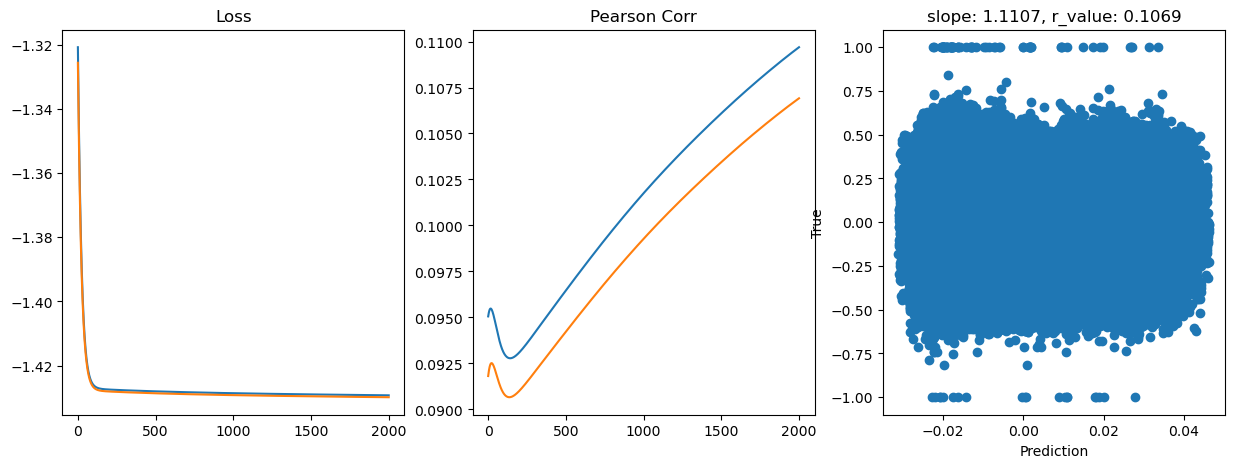

Saving model to  ./models/model_SGD_2000_lr0.001_hid_dim256

hid_dim: 512, lr: 0.75
Deleting previous model
Epoch 0, train_loss: 0.0963, val_loss: 1.0358, r_value: 0.0391
Epoch 200, train_loss: 1.0363, val_loss: 1.0358, r_value: 0.0392
Epoch 400, train_loss: 1.0363, val_loss: 1.0358, r_value: 0.0392
Epoch 600, train_loss: 1.0363, val_loss: 1.0358, r_value: 0.0394
Epoch 800, train_loss: 1.0363, val_loss: 1.0358, r_value: 0.0394
Epoch 1000, train_loss: 1.0363, val_loss: 1.0358, r_value: 0.0396
Epoch 1200, train_loss: 1.0363, val_loss: 1.0358, r_value: 0.0397
Epoch 1400, train_loss: 1.0363, val_loss: 1.0358, r_value: 0.0399
Epoch 1600, train_loss: 1.0363, val_loss: 1.0358, r_value: 0.0401
Epoch 1800, train_loss: 1.0363, val_loss: 1.0358, r_value: 0.0403


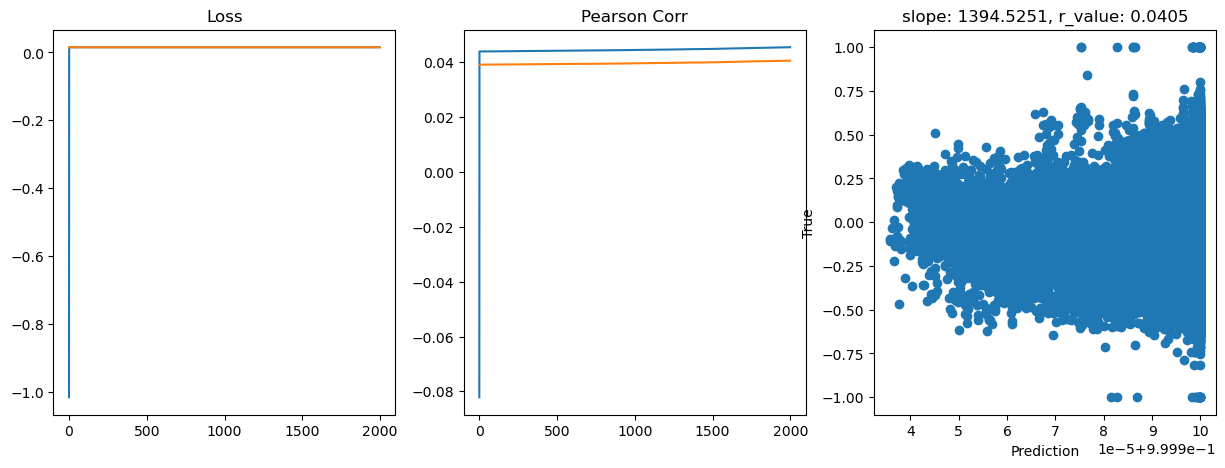

Saving model to  ./models/model_SGD_2000_lr0.75_hid_dim512

hid_dim: 512, lr: 0.5
Deleting previous model
Epoch 0, train_loss: 0.0477, val_loss: 1.0095, r_value: 0.0546
Epoch 200, train_loss: 0.0369, val_loss: 0.0368, r_value: 0.1452
Epoch 400, train_loss: 0.0371, val_loss: 0.0370, r_value: 0.1620
Epoch 600, train_loss: 0.0370, val_loss: 0.0370, r_value: 0.1669
Epoch 800, train_loss: 0.0370, val_loss: 0.0370, r_value: 0.1699
Epoch 1000, train_loss: 0.0370, val_loss: 0.0369, r_value: 0.1725
Epoch 1200, train_loss: 0.0370, val_loss: 0.0369, r_value: 0.1749
Epoch 1400, train_loss: 0.0370, val_loss: 0.0369, r_value: 0.1769
Epoch 1600, train_loss: 0.0369, val_loss: 0.0369, r_value: 0.1787
Epoch 1800, train_loss: 0.0369, val_loss: 0.0369, r_value: 0.1804


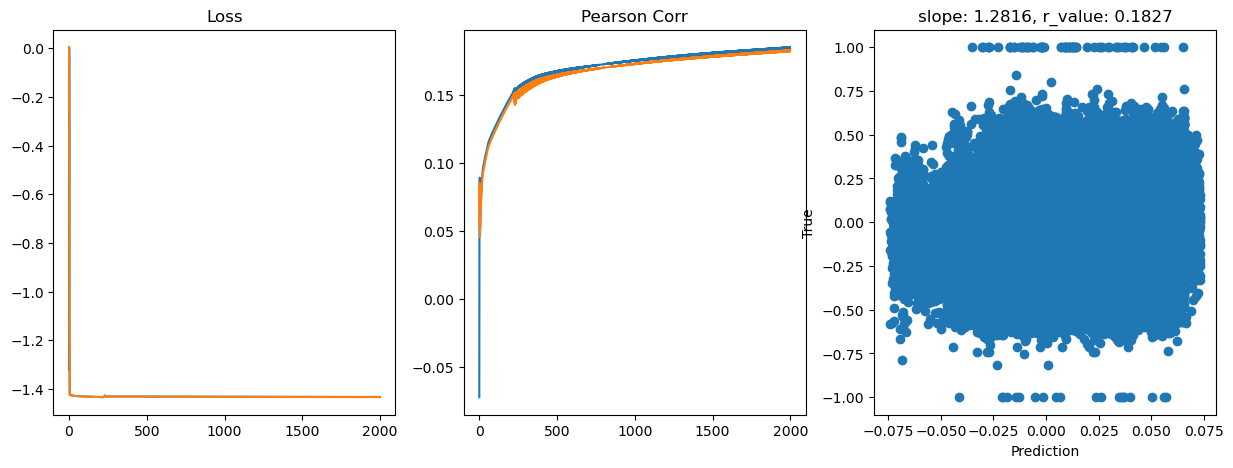

Saving model to  ./models/model_SGD_2000_lr0.5_hid_dim512

hid_dim: 512, lr: 0.1
Deleting previous model
Epoch 0, train_loss: 0.0394, val_loss: 0.0739, r_value: 0.0666
Epoch 200, train_loss: 0.0370, val_loss: 0.0370, r_value: 0.1298
Epoch 400, train_loss: 0.0369, val_loss: 0.0369, r_value: 0.1405
Epoch 600, train_loss: 0.0369, val_loss: 0.0368, r_value: 0.1489
Epoch 800, train_loss: 0.0368, val_loss: 0.0367, r_value: 0.1565
Epoch 1000, train_loss: 0.0367, val_loss: 0.0367, r_value: 0.1628
Epoch 1200, train_loss: 0.0366, val_loss: 0.0366, r_value: 0.1681
Epoch 1400, train_loss: 0.0366, val_loss: 0.0365, r_value: 0.1725
Epoch 1600, train_loss: 0.0365, val_loss: 0.0365, r_value: 0.1761
Epoch 1800, train_loss: 0.0365, val_loss: 0.0364, r_value: 0.1791


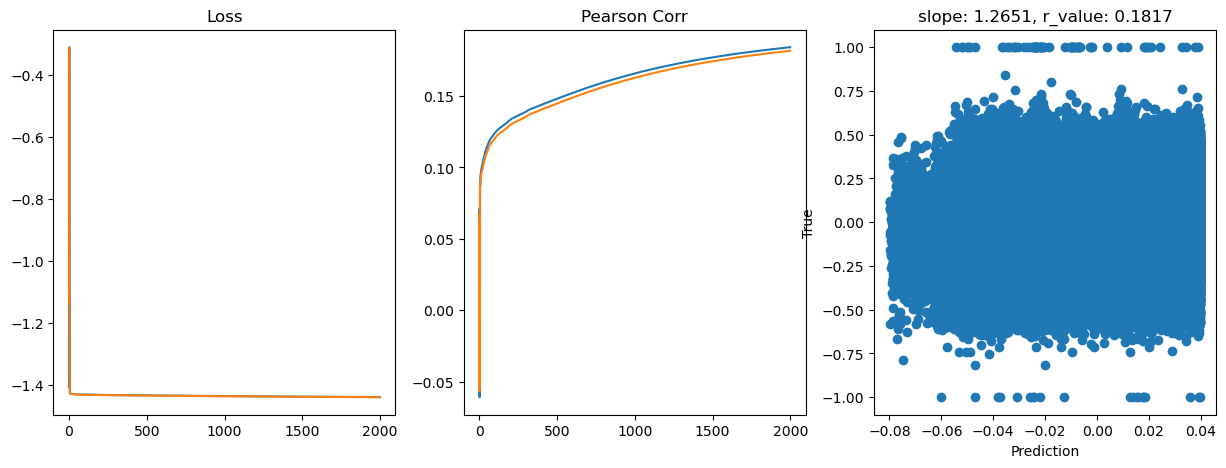

Saving model to  ./models/model_SGD_2000_lr0.1_hid_dim512

hid_dim: 512, lr: 0.01
Deleting previous model
Epoch 0, train_loss: 0.0389, val_loss: 0.0385, r_value: -0.0888
Epoch 200, train_loss: 0.0373, val_loss: 0.0372, r_value: 0.1009
Epoch 400, train_loss: 0.0372, val_loss: 0.0371, r_value: 0.1133
Epoch 600, train_loss: 0.0371, val_loss: 0.0371, r_value: 0.1194
Epoch 800, train_loss: 0.0371, val_loss: 0.0370, r_value: 0.1233
Epoch 1000, train_loss: 0.0371, val_loss: 0.0370, r_value: 0.1274
Epoch 1200, train_loss: 0.0370, val_loss: 0.0370, r_value: 0.1304
Epoch 1400, train_loss: 0.0370, val_loss: 0.0370, r_value: 0.1327
Epoch 1600, train_loss: 0.0370, val_loss: 0.0369, r_value: 0.1347
Epoch 1800, train_loss: 0.0370, val_loss: 0.0369, r_value: 0.1366


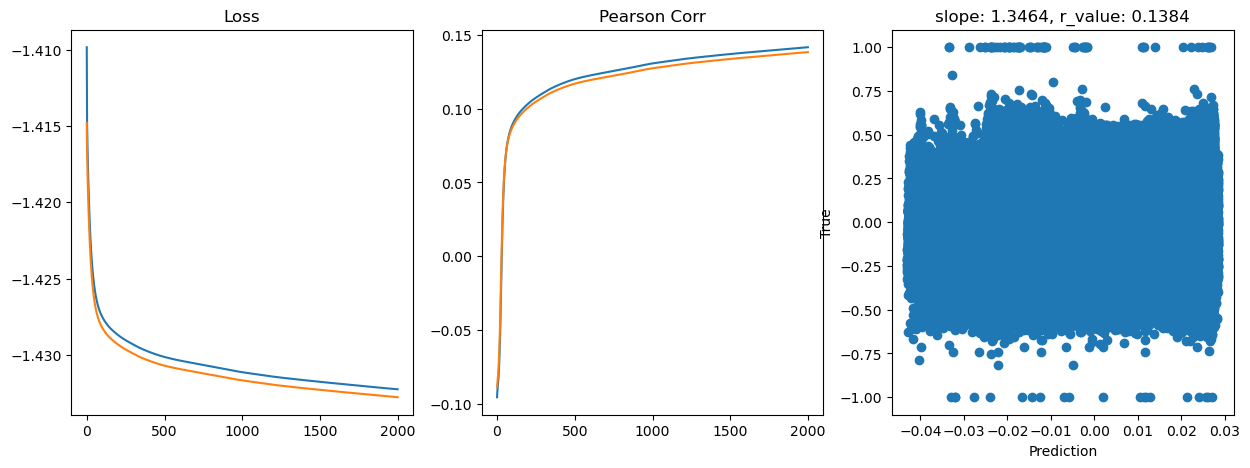

Saving model to  ./models/model_SGD_2000_lr0.01_hid_dim512

hid_dim: 512, lr: 0.05
Deleting previous model
Epoch 0, train_loss: 0.0421, val_loss: 0.0434, r_value: 0.0455
Epoch 200, train_loss: 0.0370, val_loss: 0.0370, r_value: 0.1327
Epoch 400, train_loss: 0.0369, val_loss: 0.0369, r_value: 0.1436
Epoch 600, train_loss: 0.0369, val_loss: 0.0368, r_value: 0.1507
Epoch 800, train_loss: 0.0368, val_loss: 0.0367, r_value: 0.1562
Epoch 1000, train_loss: 0.0367, val_loss: 0.0367, r_value: 0.1609
Epoch 1200, train_loss: 0.0367, val_loss: 0.0367, r_value: 0.1649
Epoch 1400, train_loss: 0.0367, val_loss: 0.0366, r_value: 0.1680
Epoch 1600, train_loss: 0.0366, val_loss: 0.0366, r_value: 0.1704
Epoch 1800, train_loss: 0.0367, val_loss: 0.0367, r_value: 0.1720


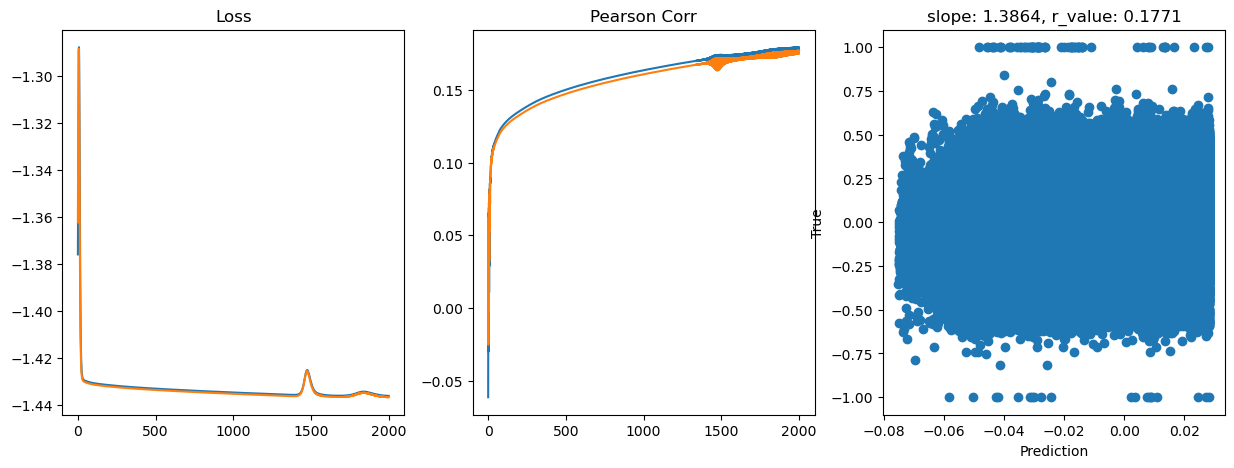

Saving model to  ./models/model_SGD_2000_lr0.05_hid_dim512

hid_dim: 512, lr: 0.001
Deleting previous model
Epoch 0, train_loss: 0.0465, val_loss: 0.0455, r_value: -0.0101
Epoch 200, train_loss: 0.0377, val_loss: 0.0376, r_value: 0.0107
Epoch 400, train_loss: 0.0375, val_loss: 0.0374, r_value: 0.0807
Epoch 600, train_loss: 0.0374, val_loss: 0.0373, r_value: 0.0939
Epoch 800, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0984
Epoch 1000, train_loss: 0.0373, val_loss: 0.0372, r_value: 0.1008
Epoch 1200, train_loss: 0.0373, val_loss: 0.0372, r_value: 0.1027
Epoch 1400, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1043
Epoch 1600, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1059
Epoch 1800, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1075


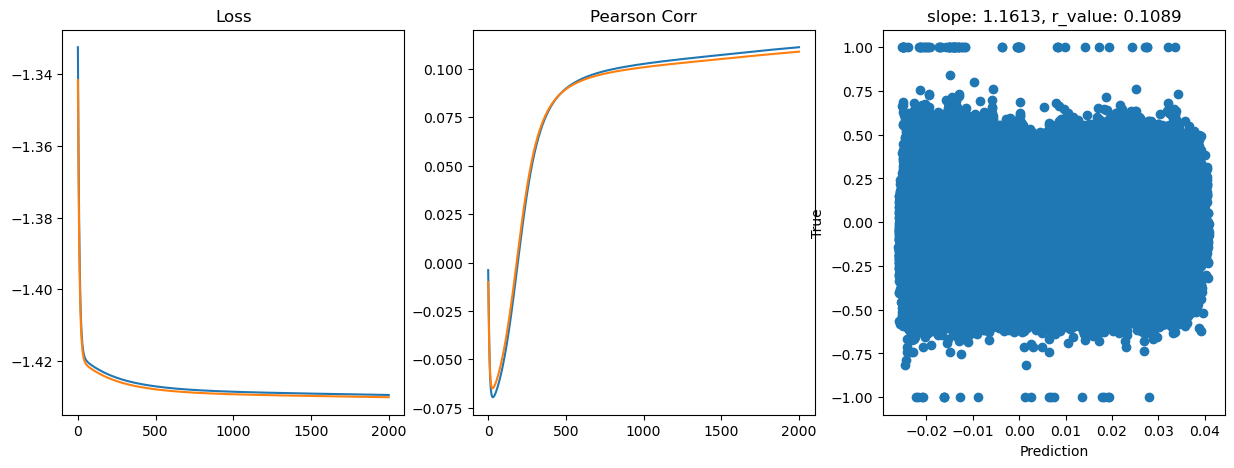

Saving model to  ./models/model_SGD_2000_lr0.001_hid_dim512


In [37]:
# model.train()
epochs = 2000
hid_dim_range = [128,256,512]
lr_range = [0.75,0.5,0.1,0.01,0.05,0.001]

#Let's create a place to save these models, so we can 
path_to_save_models = './models'
if not os.path.exists(path_to_save_models):
    os.makedirs(path_to_save_models)

for hid_dim in hid_dim_range:
    for lr in lr_range:
        print('\nhid_dim: {}, lr: {}'.format(hid_dim, lr))
        if 'model' in globals():
            print('Deleting previous model')
            del model, criterion, optimizer
        model = Feedforward(2, hid_dim).to(device)
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr = lr)

        all_loss_train=[]
        all_loss_val=[]
        all_r_train=[]
        all_r_val=[]
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(X_train.to(device))
            # Compute Loss
            loss = criterion(y_pred.squeeze(), y_train.to(device))

            # Backward pass
            loss.backward()
            optimizer.step()

            all_loss_train.append(loss.item())
            y_pred = y_pred.cpu().detach().numpy().squeeze()
            _, _, r_value_train, _, _ = scipy.stats.linregress(y_pred, y_train)
            all_r_train.append(r_value_train)

            model.eval()
            with torch.no_grad():
                y_pred = model(X_test.to(device))
                # Compute Loss
                loss = criterion(y_pred.squeeze(), y_test.to(device))
                all_loss_val.append(loss.item())
                
                y_pred = y_pred.cpu().detach().numpy().squeeze()
                slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_test)
                all_r_val.append(r_value)
            
                if epoch%200==0:
                    print('Epoch {}, train_loss: {:.4f}, val_loss: {:.4f}, r_value: {:.4f}'.format(epoch,all_loss_train[-1],all_loss_val[-1],r_value))
                
        fig,ax=plt.subplots(1,3,figsize=(15,5))
        ax[0].plot(np.log10(all_loss_train))
        ax[0].plot(np.log10(all_loss_val))
        ax[0].set_title('Loss')
        
        ax[1].plot(all_r_train)
        ax[1].plot(all_r_val)
        ax[1].set_title('Pearson Corr')

        ax[2].scatter(y_pred, y_test.cpu())
        ax[2].set_xlabel('Prediction')
        ax[2].set_ylabel('True')
        ax[2].set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))
        plt.show()
        
        name_to_save = os.path.join(path_to_save_models,'model_SGD_' + str(epochs) + '_lr' + str(lr) + '_hid_dim' + str(hid_dim))
        print('Saving model to ', name_to_save)
        model_state = {
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'optimizer' : optimizer.state_dict(),
            }
        torch.save(model_state, name_to_save +'.pt')

In [38]:
# Try deeper FF
class Feedforward(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.fc3 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.fc4 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc5 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
    def forward(self, x):
        hidden = self.relu(self.fc1(x))
        hidden = self.relu(self.fc2(hidden))
        hidden = self.relu(self.fc3(hidden))
        hidden = self.relu(self.fc4(hidden))
        output = self.tanh(self.fc5(hidden))

        return output


hid_dim: 128, lr: 0.5
Deleting previous model
Epoch 0, train_loss: 0.0503, val_loss: 0.0428, r_value: -0.0330
Epoch 200, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1042
Epoch 400, train_loss: 0.0372, val_loss: 0.0371, r_value: 0.1125
Epoch 600, train_loss: 0.0371, val_loss: 0.0371, r_value: 0.1212
Epoch 800, train_loss: 0.0371, val_loss: 0.0371, r_value: 0.1307
Epoch 1000, train_loss: 0.0371, val_loss: 0.0371, r_value: 0.1403
Epoch 1200, train_loss: 0.0371, val_loss: 0.0370, r_value: 0.1507
Epoch 1400, train_loss: 0.0370, val_loss: 0.0369, r_value: 0.1604
Epoch 1600, train_loss: 0.0369, val_loss: 0.0368, r_value: 0.1686
Epoch 1800, train_loss: 0.0368, val_loss: 0.0368, r_value: 0.1752


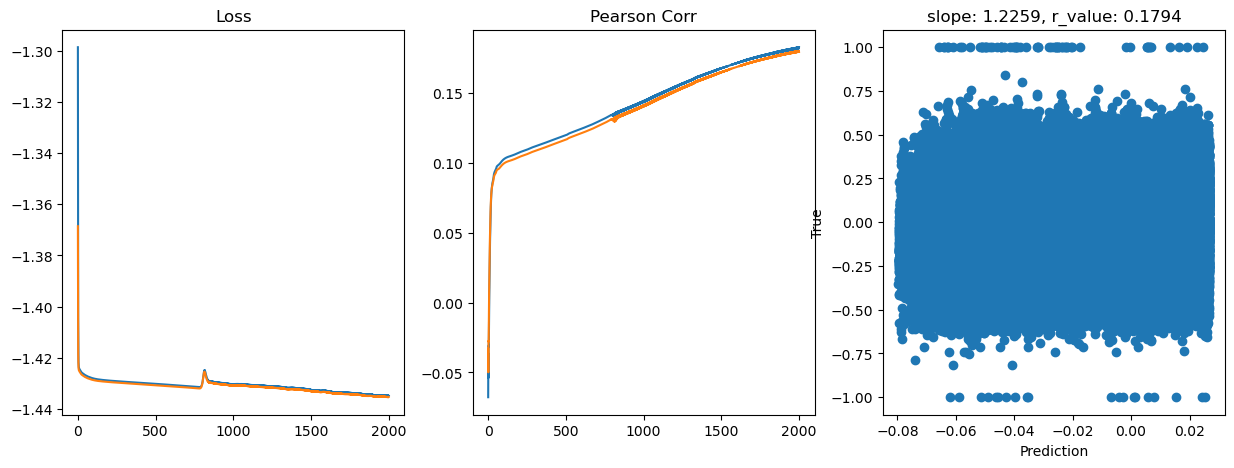

Saving model to  ./models/model_SGD_Deeper2000_lr0.5_hid_dim128

hid_dim: 128, lr: 0.1
Deleting previous model
Epoch 0, train_loss: 0.0437, val_loss: 0.0401, r_value: -0.0549
Epoch 200, train_loss: 0.0374, val_loss: 0.0373, r_value: 0.0946
Epoch 400, train_loss: 0.0373, val_loss: 0.0372, r_value: 0.0976
Epoch 600, train_loss: 0.0373, val_loss: 0.0372, r_value: 0.1006
Epoch 800, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1029
Epoch 1000, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1048
Epoch 1200, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1068
Epoch 1400, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1089
Epoch 1600, train_loss: 0.0372, val_loss: 0.0371, r_value: 0.1111
Epoch 1800, train_loss: 0.0372, val_loss: 0.0371, r_value: 0.1131


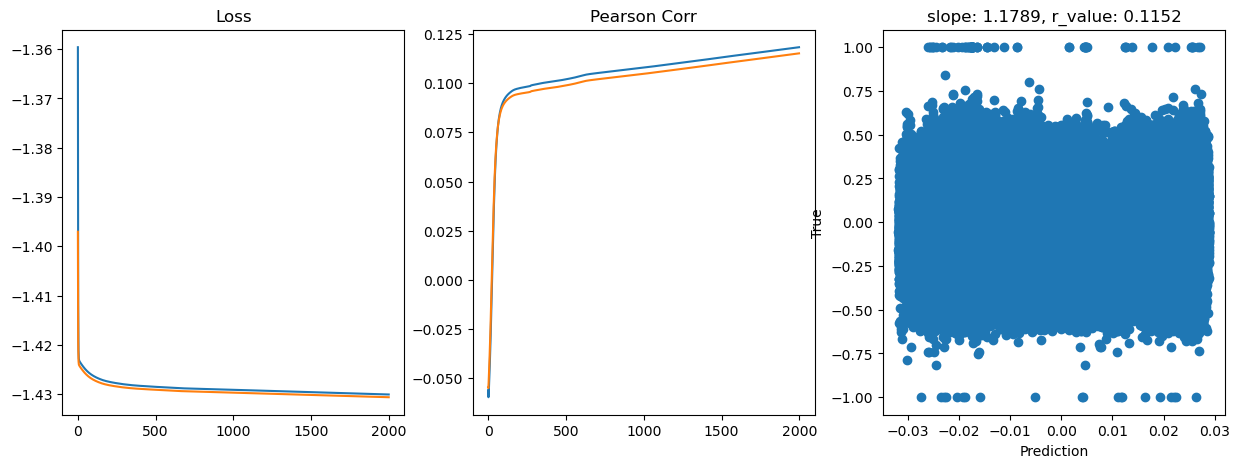

Saving model to  ./models/model_SGD_Deeper2000_lr0.1_hid_dim128

hid_dim: 128, lr: 0.01
Deleting previous model
Epoch 0, train_loss: 0.0484, val_loss: 0.0477, r_value: -0.0230
Epoch 200, train_loss: 0.0375, val_loss: 0.0375, r_value: 0.0971
Epoch 400, train_loss: 0.0375, val_loss: 0.0374, r_value: 0.0967
Epoch 600, train_loss: 0.0375, val_loss: 0.0374, r_value: 0.0958
Epoch 800, train_loss: 0.0374, val_loss: 0.0374, r_value: 0.0956
Epoch 1000, train_loss: 0.0374, val_loss: 0.0374, r_value: 0.0958
Epoch 1200, train_loss: 0.0374, val_loss: 0.0373, r_value: 0.0962
Epoch 1400, train_loss: 0.0374, val_loss: 0.0373, r_value: 0.0966
Epoch 1600, train_loss: 0.0374, val_loss: 0.0373, r_value: 0.0971
Epoch 1800, train_loss: 0.0374, val_loss: 0.0373, r_value: 0.0977


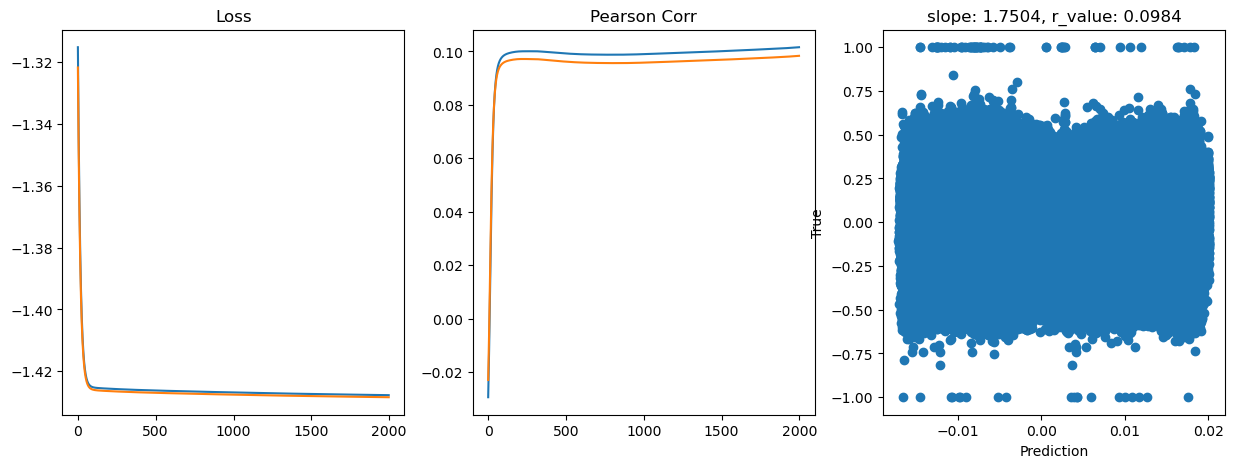

Saving model to  ./models/model_SGD_Deeper2000_lr0.01_hid_dim128

hid_dim: 128, lr: 0.05
Deleting previous model
Epoch 0, train_loss: 0.0399, val_loss: 0.0391, r_value: 0.1013
Epoch 200, train_loss: 0.0374, val_loss: 0.0373, r_value: 0.1016
Epoch 400, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.1008
Epoch 600, train_loss: 0.0373, val_loss: 0.0372, r_value: 0.1022
Epoch 800, train_loss: 0.0373, val_loss: 0.0372, r_value: 0.1036
Epoch 1000, train_loss: 0.0373, val_loss: 0.0372, r_value: 0.1047
Epoch 1200, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1058
Epoch 1400, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1067
Epoch 1600, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1076
Epoch 1800, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1089


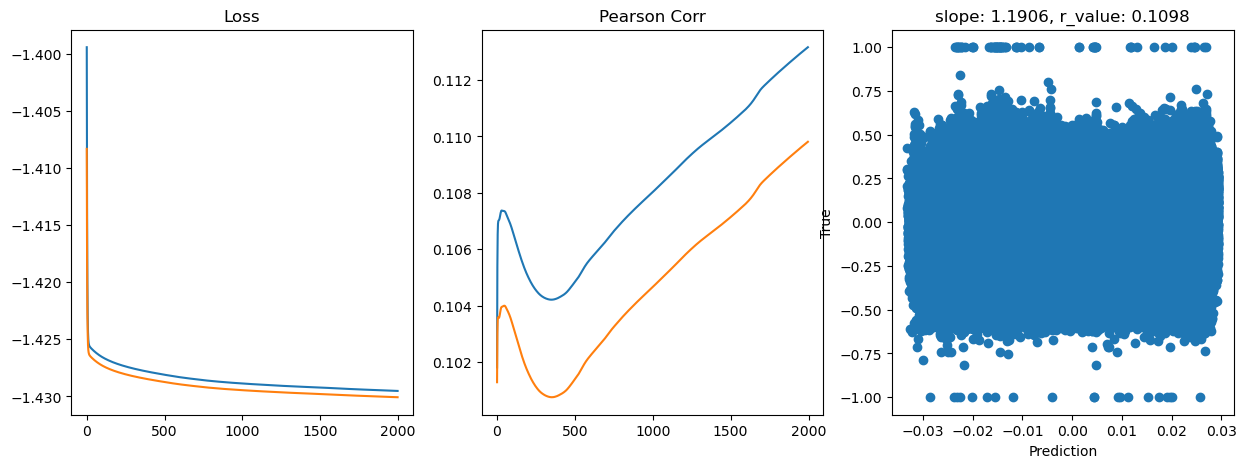

Saving model to  ./models/model_SGD_Deeper2000_lr0.05_hid_dim128

hid_dim: 256, lr: 0.5
Deleting previous model
Epoch 0, train_loss: 0.0380, val_loss: 0.0379, r_value: -0.0041
Epoch 200, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1165
Epoch 400, train_loss: 0.0372, val_loss: 0.0371, r_value: 0.1286
Epoch 600, train_loss: 0.0371, val_loss: 0.0371, r_value: 0.1419
Epoch 800, train_loss: 0.0371, val_loss: 0.0370, r_value: 0.1547
Epoch 1000, train_loss: 0.0370, val_loss: 0.0369, r_value: 0.1651
Epoch 1200, train_loss: 0.0369, val_loss: 0.0368, r_value: 0.1733
Epoch 1400, train_loss: 0.0368, val_loss: 0.0367, r_value: 0.1790
Epoch 1600, train_loss: 0.0367, val_loss: 0.0366, r_value: 0.1836
Epoch 1800, train_loss: 0.0366, val_loss: 0.0366, r_value: 0.1875


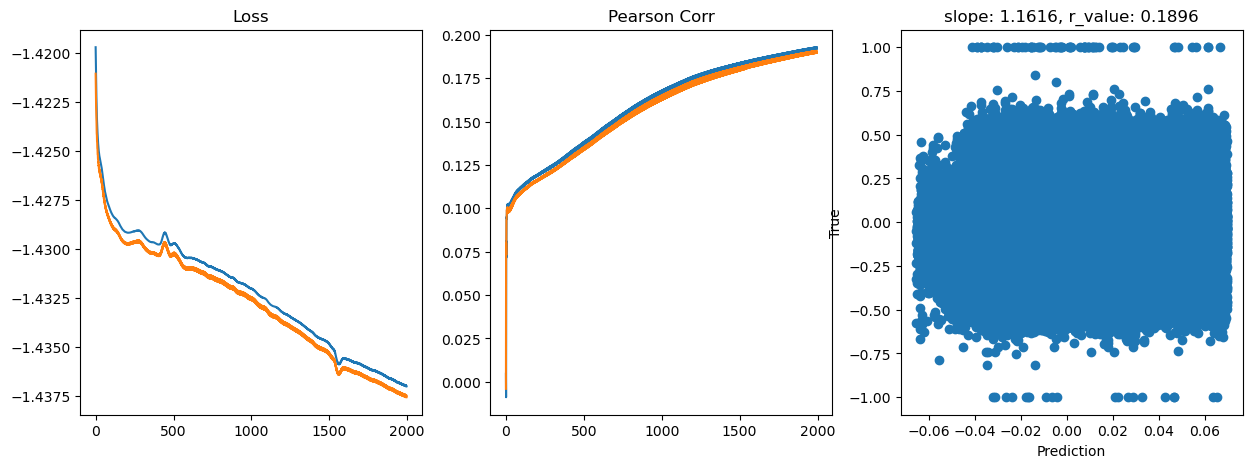

Saving model to  ./models/model_SGD_Deeper2000_lr0.5_hid_dim256

hid_dim: 256, lr: 0.1
Deleting previous model
Epoch 0, train_loss: 0.0406, val_loss: 0.0385, r_value: 0.0544
Epoch 200, train_loss: 0.0373, val_loss: 0.0372, r_value: 0.1062
Epoch 400, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1109
Epoch 600, train_loss: 0.0372, val_loss: 0.0371, r_value: 0.1143
Epoch 800, train_loss: 0.0371, val_loss: 0.0371, r_value: 0.1170
Epoch 1000, train_loss: 0.0371, val_loss: 0.0371, r_value: 0.1204
Epoch 1200, train_loss: 0.0371, val_loss: 0.0370, r_value: 0.1233
Epoch 1400, train_loss: 0.0371, val_loss: 0.0370, r_value: 0.1267
Epoch 1600, train_loss: 0.0370, val_loss: 0.0370, r_value: 0.1299
Epoch 1800, train_loss: 0.0370, val_loss: 0.0370, r_value: 0.1329


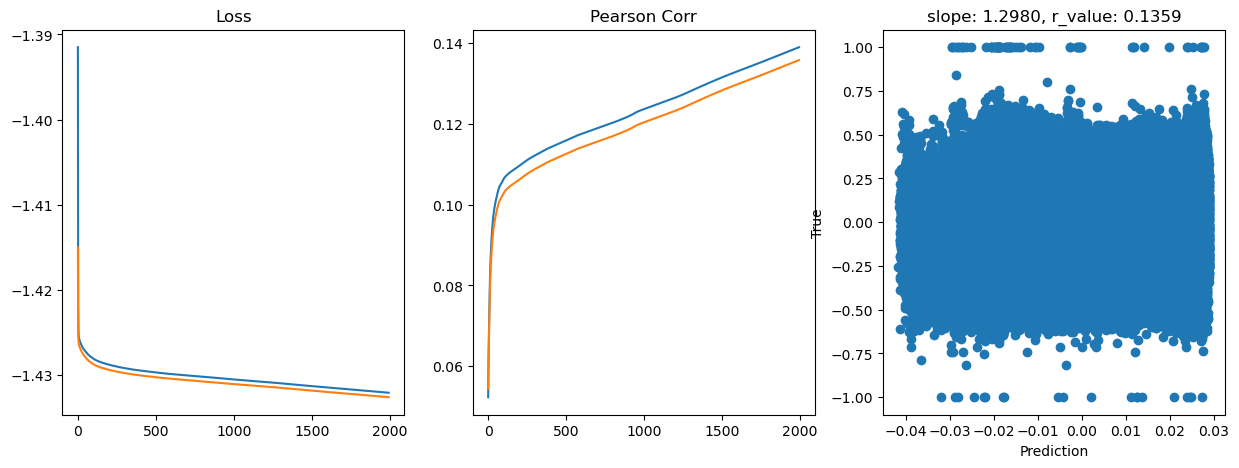

Saving model to  ./models/model_SGD_Deeper2000_lr0.1_hid_dim256

hid_dim: 256, lr: 0.01
Deleting previous model
Epoch 0, train_loss: 0.0381, val_loss: 0.0380, r_value: -0.0578
Epoch 200, train_loss: 0.0376, val_loss: 0.0375, r_value: 0.0614
Epoch 400, train_loss: 0.0375, val_loss: 0.0374, r_value: 0.0917
Epoch 600, train_loss: 0.0375, val_loss: 0.0374, r_value: 0.0954
Epoch 800, train_loss: 0.0374, val_loss: 0.0373, r_value: 0.0965
Epoch 1000, train_loss: 0.0374, val_loss: 0.0373, r_value: 0.0973
Epoch 1200, train_loss: 0.0374, val_loss: 0.0373, r_value: 0.0981
Epoch 1400, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0988
Epoch 1600, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0994
Epoch 1800, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.0999


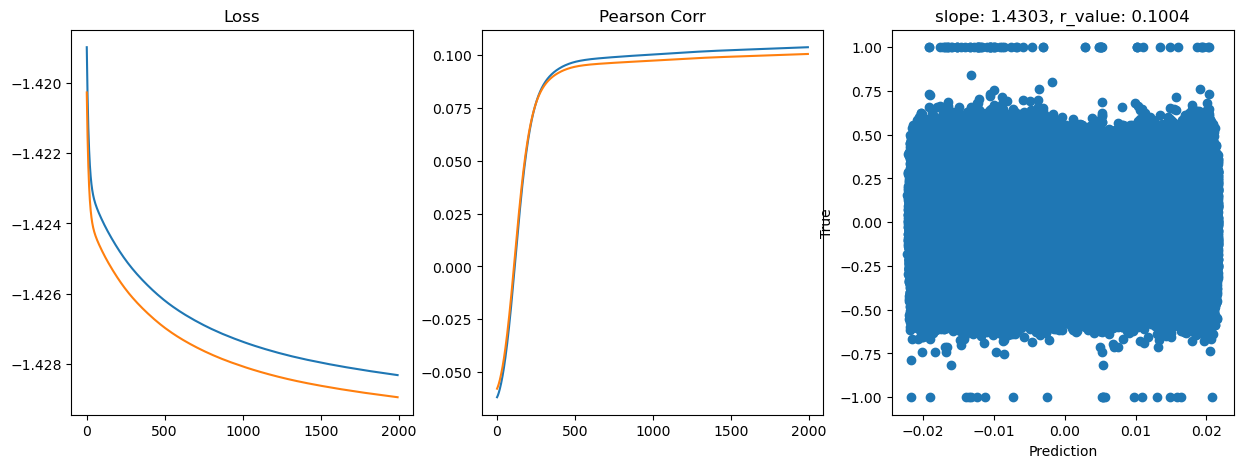

Saving model to  ./models/model_SGD_Deeper2000_lr0.01_hid_dim256

hid_dim: 256, lr: 0.05
Deleting previous model
Epoch 0, train_loss: 0.0396, val_loss: 0.0388, r_value: -0.0103
Epoch 200, train_loss: 0.0374, val_loss: 0.0373, r_value: 0.0993
Epoch 400, train_loss: 0.0373, val_loss: 0.0372, r_value: 0.1028
Epoch 600, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1056
Epoch 800, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1081
Epoch 1000, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1098
Epoch 1200, train_loss: 0.0372, val_loss: 0.0371, r_value: 0.1117
Epoch 1400, train_loss: 0.0372, val_loss: 0.0371, r_value: 0.1134
Epoch 1600, train_loss: 0.0372, val_loss: 0.0371, r_value: 0.1147
Epoch 1800, train_loss: 0.0371, val_loss: 0.0371, r_value: 0.1161


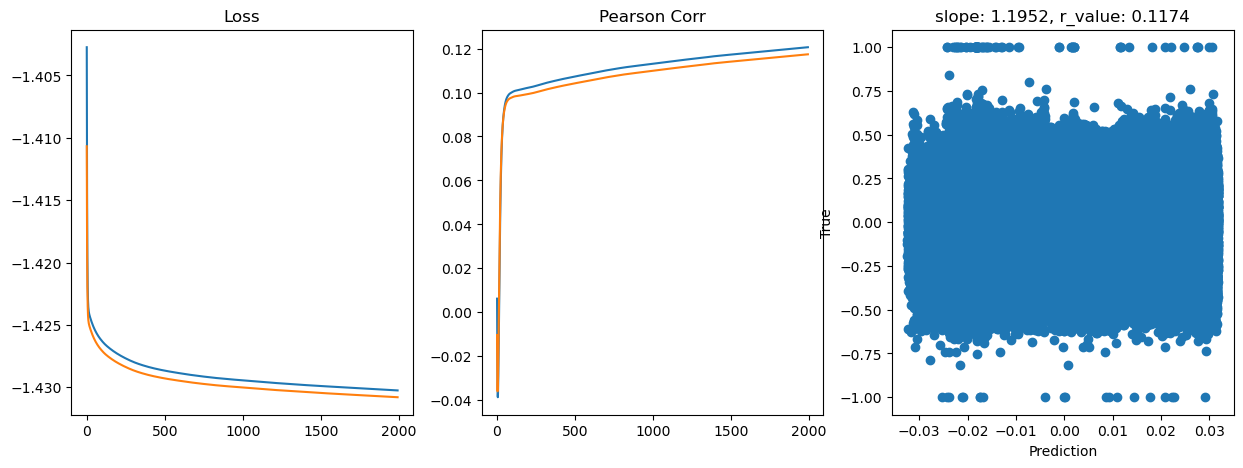

Saving model to  ./models/model_SGD_Deeper2000_lr0.05_hid_dim256

hid_dim: 512, lr: 0.5
Deleting previous model
Epoch 0, train_loss: 0.0380, val_loss: 0.0386, r_value: 0.0792
Epoch 200, train_loss: 0.0371, val_loss: 0.0370, r_value: 0.1242
Epoch 400, train_loss: 0.0370, val_loss: 0.0370, r_value: 0.1427
Epoch 600, train_loss: 0.0370, val_loss: 0.0369, r_value: 0.1593
Epoch 800, train_loss: 0.0368, val_loss: 0.0368, r_value: 0.1723
Epoch 1000, train_loss: 0.0367, val_loss: 0.0367, r_value: 0.1812
Epoch 1200, train_loss: 0.0366, val_loss: 0.0365, r_value: 0.1874
Epoch 1400, train_loss: 0.0365, val_loss: 0.0364, r_value: 0.1923
Epoch 1600, train_loss: 0.0364, val_loss: 0.0364, r_value: 0.1958
Epoch 1800, train_loss: 0.0363, val_loss: 0.0363, r_value: 0.1988


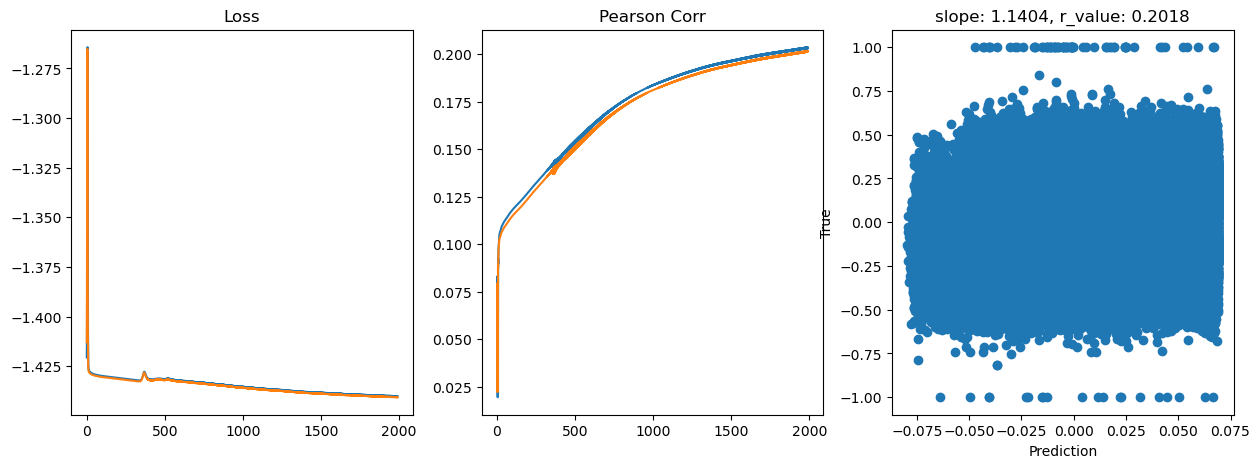

Saving model to  ./models/model_SGD_Deeper2000_lr0.5_hid_dim512

hid_dim: 512, lr: 0.1
Deleting previous model
Epoch 0, train_loss: 0.0382, val_loss: 0.0379, r_value: -0.0825
Epoch 200, train_loss: 0.0372, val_loss: 0.0371, r_value: 0.1135
Epoch 400, train_loss: 0.0371, val_loss: 0.0371, r_value: 0.1212
Epoch 600, train_loss: 0.0371, val_loss: 0.0370, r_value: 0.1263
Epoch 800, train_loss: 0.0370, val_loss: 0.0370, r_value: 0.1311
Epoch 1000, train_loss: 0.0370, val_loss: 0.0369, r_value: 0.1357
Epoch 1200, train_loss: 0.0369, val_loss: 0.0369, r_value: 0.1402
Epoch 1400, train_loss: 0.0369, val_loss: 0.0369, r_value: 0.1446
Epoch 1600, train_loss: 0.0369, val_loss: 0.0368, r_value: 0.1490
Epoch 1800, train_loss: 0.0368, val_loss: 0.0368, r_value: 0.1534


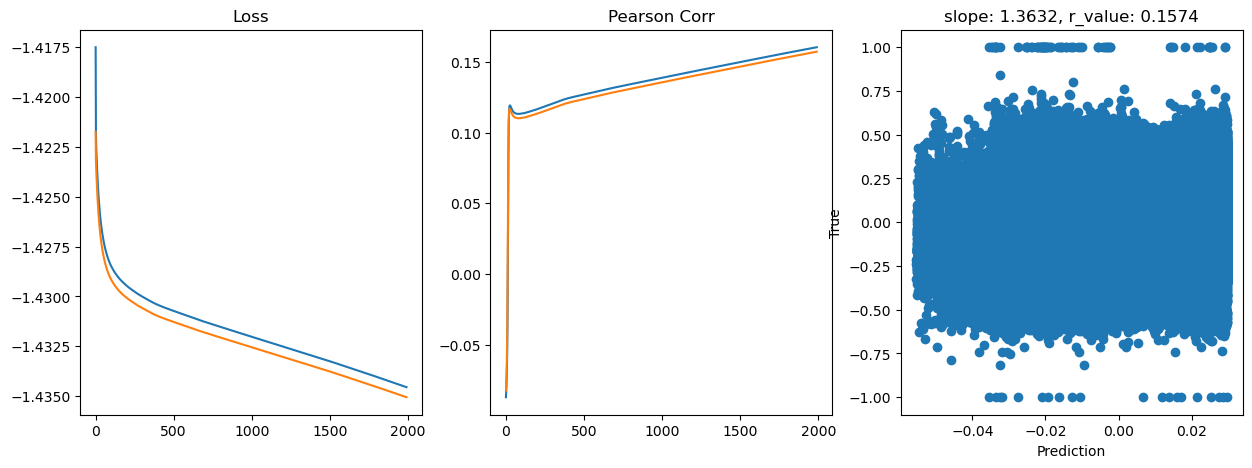

Saving model to  ./models/model_SGD_Deeper2000_lr0.1_hid_dim512

hid_dim: 512, lr: 0.01
Deleting previous model
Epoch 0, train_loss: 0.0378, val_loss: 0.0377, r_value: -0.0290
Epoch 200, train_loss: 0.0375, val_loss: 0.0374, r_value: 0.1043
Epoch 400, train_loss: 0.0374, val_loss: 0.0373, r_value: 0.1052
Epoch 600, train_loss: 0.0373, val_loss: 0.0373, r_value: 0.1059
Epoch 800, train_loss: 0.0373, val_loss: 0.0372, r_value: 0.1067
Epoch 1000, train_loss: 0.0373, val_loss: 0.0372, r_value: 0.1074
Epoch 1200, train_loss: 0.0373, val_loss: 0.0372, r_value: 0.1081
Epoch 1400, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1089
Epoch 1600, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1096
Epoch 1800, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1103


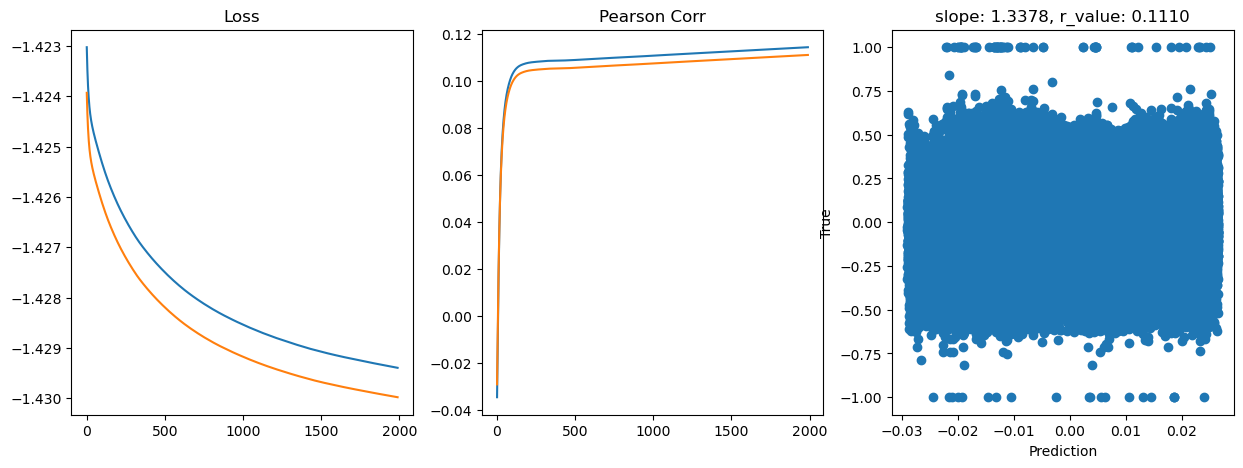

Saving model to  ./models/model_SGD_Deeper2000_lr0.01_hid_dim512

hid_dim: 512, lr: 0.05
Deleting previous model
Epoch 0, train_loss: 0.0406, val_loss: 0.0390, r_value: 0.0797
Epoch 200, train_loss: 0.0373, val_loss: 0.0372, r_value: 0.1048
Epoch 400, train_loss: 0.0372, val_loss: 0.0372, r_value: 0.1098
Epoch 600, train_loss: 0.0372, val_loss: 0.0371, r_value: 0.1141
Epoch 800, train_loss: 0.0371, val_loss: 0.0371, r_value: 0.1171
Epoch 1000, train_loss: 0.0371, val_loss: 0.0371, r_value: 0.1196
Epoch 1200, train_loss: 0.0371, val_loss: 0.0371, r_value: 0.1221
Epoch 1400, train_loss: 0.0371, val_loss: 0.0370, r_value: 0.1244
Epoch 1600, train_loss: 0.0371, val_loss: 0.0370, r_value: 0.1267
Epoch 1800, train_loss: 0.0370, val_loss: 0.0370, r_value: 0.1289


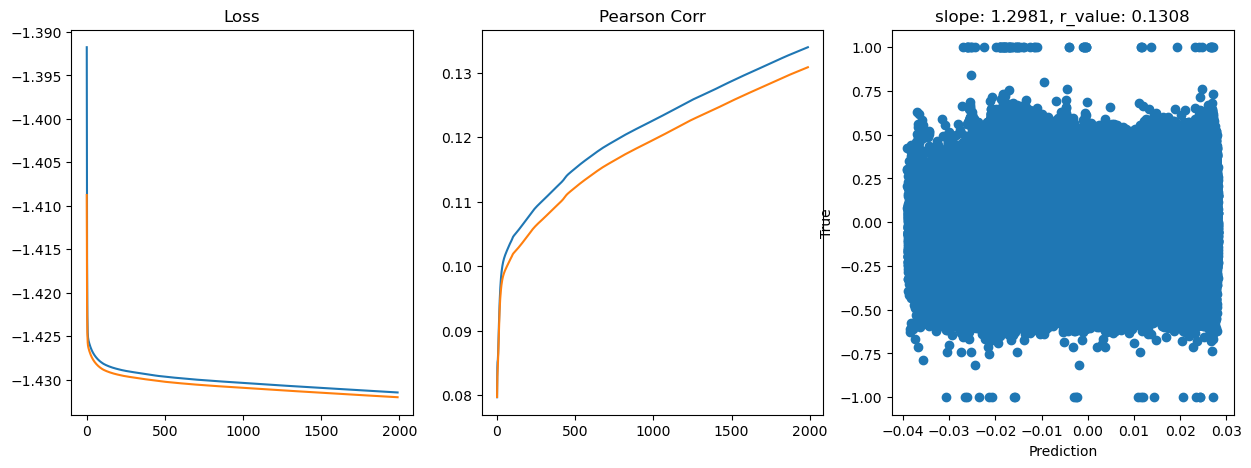

Saving model to  ./models/model_SGD_Deeper2000_lr0.05_hid_dim512


In [44]:
# model.train()
epoch = 2000
hid_dim_range = [128,256,512]
lr_range = [0.5,0.1,0.01,0.05]

for hid_dim in hid_dim_range:
    for lr in lr_range:
        print('\nhid_dim: {}, lr: {}'.format(hid_dim, lr))
        if 'model' in globals():
            print('Deleting previous model')
            del model, criterion, optimizer
        model = Feedforward(2, hid_dim).to(device)
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr = lr)

        all_loss_train=[]
        all_loss_val=[]
        all_r_train=[]
        all_r_val=[]
        for epoch in range(epoch):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(X_train.to(device))
            # Compute Loss
            loss = criterion(y_pred.squeeze(), y_train.to(device))

            # Backward pass
            loss.backward()
            optimizer.step()

            all_loss_train.append(loss.item())
            y_pred = y_pred.cpu().detach().numpy().squeeze()
            _, _, r_value_train, _, _ = scipy.stats.linregress(y_pred, y_train)
            all_r_train.append(r_value_train)

            model.eval()
            with torch.no_grad():
                y_pred = model(X_test.to(device))
                # Compute Loss
                loss = criterion(y_pred.squeeze(), y_test.to(device))
                all_loss_val.append(loss.item())
            
                y_pred = y_pred.cpu().detach().numpy().squeeze()
                slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_test)
                all_r_val.append(r_value)
            
                if epoch%200==0:
                    print('Epoch {}, train_loss: {:.4f}, val_loss: {:.4f}, r_value: {:.4f}'.format(epoch,all_loss_train[-1],all_loss_val[-1],r_value))
                
                
        fig,ax=plt.subplots(1,3,figsize=(15,5))
        ax[0].plot(np.log10(all_loss_train))
        ax[0].plot(np.log10(all_loss_val))
        ax[0].set_title('Loss')
        
        ax[1].plot(all_r_train)
        ax[1].plot(all_r_val)
        ax[1].set_title('Pearson Corr')

        ax[2].scatter(y_pred, y_test.cpu())
        ax[2].set_xlabel('Prediction')
        ax[2].set_ylabel('True')
        ax[2].set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))
        plt.show()
        
        name_to_save = os.path.join(path_to_save_models,'model_SGD_Deeper' + str(epochs) + '_lr' + str(lr) + '_hid_dim' + str(hid_dim))
        print('Saving model to ', name_to_save)
        model_state = {
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'optimizer' : optimizer.state_dict(),
            }
        torch.save(model_state, name_to_save +'.pt')